In [2]:
%%capture
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from tensorflow.keras import regularizers
import os
import time
import numpy as np
import gc
import shutil
from tensorflow.keras.models import model_from_json
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from sklearn import preprocessing

In [3]:
def scale(x):
    
    return (x - np.mean(x)) / np.std(x)
def preprocess(x):
    
    return x[:,:,:int(0.75*x.shape[2])]

In [4]:
def get_mutitime_x(t_range,name):
    u,v,w = [],[],[]
    tau_12,tau_13,tau_23 = [],[],[]
    for t in t_range:
        uname = 'u_F_xyz_'+t+name[ini]
        vname = 'v_F_xyz_'+t+name[ini]
        wname = 'w_F_xyz_'+t+name[ini]
        tau1na = 'tau12_F_xyz_'+t+name[ini]
        tau2na = 'tau13_F_xyz_'+t+name[ini]
        tau3na = 'tau23_F_xyz_'+t+name[ini]
        utemp = preprocess(scale(loadmat(uname)["u_F"]))
        vtemp = preprocess(scale(loadmat(vname)["v_F"]))
        wtemp = preprocess(scale(loadmat(wname)["w_F"]))
        tau_12temp = preprocess(scale(loadmat(tau1na)["tau12"]))
        tau_13temp = preprocess(scale(loadmat(tau2na)["tau13"]))
        tau_23temp = preprocess(scale(loadmat(tau3na)["tau23"]))
        u.append(utemp)
        v.append(vtemp)
        w.append(wtemp)
        tau_12.append(tau_12temp)
        tau_13.append(tau_13temp)
        tau_23.append(tau_23temp)
    return np.array(u),np.array(v),np.array(w),np.array(tau_12),np.array(tau_13),np.array(tau_23)

In [5]:
path = os.getcwd()
path

'/home/ubuntu/Capstone'

In [6]:
if not os.path.exists(path + "/Train_Data"):
    os.mkdir(path + "/Train_Data")
    os.mkdir(path + "/Train_Data/Data")
    os.mkdir(path + "/Train_Data/Labels")
    os.mkdir(path + "/Train_Data/Labels/Tau_23")
    os.mkdir(path + "/Train_Data/Labels/Tau_12")
    os.mkdir(path + "/Train_Data/Labels/Tau_13")
else:
    shutil.rmtree(path + "/Train_Data") #delete the folder
    os.mkdir(path + "/Train_Data")
    os.mkdir(path + "/Train_Data/Data")
    os.mkdir(path + "/Train_Data/Labels")
    os.mkdir(path + "/Train_Data/Labels/Tau_23")
    os.mkdir(path + "/Train_Data/Labels/Tau_12")
    os.mkdir(path + "/Train_Data/Labels/Tau_13")
    
if not os.path.exists(path + "/Saved_Models_2Sets"):
    os.mkdir(path + "/Saved_Models_2Sets")

In [7]:
all_taus = False

In [8]:
counter = 1
size = 3
ini = 0
name = ['_DNS8.mat']
subdirs = ["Re15sh2_DNScoarse8","Re15sh20_DNScoarse8"]
t_range = ["T1","T2","T3","T4","T5","T6"]
for directory in subdirs:
    os.chdir(path + "/Data/" + directory)
    print("Reading: " + directory)
    u,v,w,tau_12,tau_13,tau_23 = get_mutitime_x(t_range,name)
    # Load data and check its shape
    print("Data Shape: " + str(u.shape))
    
    x = np.array([u, v, w])
    x = np.transpose(x, [1, 2, 3,4, 0])
    x = np.pad(x, ((0,0),(size,size), (size,size), (size,size), (0,0)), 'constant', constant_values = 0)
    print("x.shape:",x.shape)
    del u
    del v
    del w
    gc.collect()
    
    sample = []
    y_tau_23 = []
    y_tau_12 = []
    y_tau_13 = []
    num_files = 10

    x_range = np.arange(size, x.shape[1] - size)
    np.random.shuffle(x_range)
    y_range = np.arange(size, x.shape[2] - size)
    np.random.shuffle(y_range)
    z_range = np.arange(size, x.shape[3] - size)
    np.random.shuffle(z_range)
    for i in x_range:
        for j in y_range:
            for k in z_range:
                sample.append(x[:,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :])
                y_tau_23.append([tau_23[t][i - size][j - size][k - size] for t in range(6)])
                y_tau_12.append([tau_23[t][i - size][j - size][k - size] for t in range(6)])
                y_tau_13.append([tau_23[t][i - size][j - size][k - size] for t in range(6)])
                

                if len(sample) == int(((x.shape[1] - size * 2) * (x.shape[2] - size * 2) * (x.shape[3] - size * 2)) / num_files):
                    os.chdir(path + "/Train_Data/Data")
                    np.save(str(counter), np.array(sample))
                    os.chdir(path + "/Train_Data/Labels/Tau_23")
                    np.save(str(counter), np.array(y_tau_23))
                    os.chdir(path + "/Train_Data/Labels/Tau_12")
                    np.save(str(counter), np.array(y_tau_12))
                    os.chdir(path + "/Train_Data/Labels/Tau_13")
                    np.save(str(counter), np.array(y_tau_13))

                    del sample
                    del y_tau_13
                    del y_tau_12
                    del y_tau_23
                    gc.collect()
                    sample = []
                    y_tau_23 = []
                    y_tau_12 = []
                    y_tau_13 = []
                    
                    counter += 1
    del x
    del tau_12
    del tau_13
    del tau_23
    gc.collect()
    print("x.shape:",np.array(sample).shape)
    print("y.shape:",np.array(y_tau_13).shape)
    print("Saved " + directory + " to disk\n")

Reading: Re15sh2_DNScoarse8
Data Shape: (6, 146, 96, 54)
x.shape: (6, 152, 102, 60, 3)
x.shape: (4, 6, 7, 7, 7, 3)
y.shape: (4, 6)
Saved Re15sh2_DNScoarse8 to disk

Reading: Re15sh20_DNScoarse8
Data Shape: (6, 146, 96, 56)
x.shape: (6, 152, 102, 62, 3)
x.shape: (6, 6, 7, 7, 7, 3)
y.shape: (6, 6)
Saved Re15sh20_DNScoarse8 to disk



In [9]:
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import TimeDistributed
from keras.layers import LSTM
class LSTM(object):
    
    def __init__(self, activation, initializer, regularizer, input_shape):
        self.activation = activation
        self.initializer = initializer
        self.regularizer = regularizer
        self.input_shape = input_shape
        
        pass 
    
    def create_model(self):
        model = tf.keras.Sequential()#[
        model.add(tf.keras.layers.LSTM(16,input_shape=self.input_shape,return_sequences = True))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1,activation = self.activation)))

        return model


Using TensorFlow backend.


Box size used: (7, 7, 7, 3)

Predicting Tau_12

Running Dataset:Tau_12: Epoch: 0: fileSet: 11
Train on 50087 samples, validate on 12522 samples
Epoch 1/1
50087/50087 [==============================] - 22s 448us/step - loss: 1.3468 - val_loss: 1.2769

Running Dataset:Tau_12: Epoch: 0: fileSet: 1
Train on 48422 samples, validate on 12106 samples
Epoch 1/1
48422/48422 [==============================] - 3s 66us/step - loss: 1.2324 - val_loss: 1.1940

Running Dataset:Tau_12: Epoch: 0: fileSet: 14
Train on 50310 samples, validate on 12578 samples
Epoch 1/1
50310/50310 [==============================] - 3s 61us/step - loss: 1.2155 - val_loss: 1.1732

Running Dataset:Tau_12: Epoch: 0: fileSet: 9
Train on 48459 samples, validate on 12115 samples
Epoch 1/1
48459/48459 [==============================] - 3s 61us/step - loss: 1.1398 - val_loss: 1.2841

Running Dataset:Tau_12: Epoch: 0: fileSet: 5
Train on 48426 samples, validate on 12107 samples
Epoch 1/1
48426/48426 [==============================

48339/48339 [==============================] - 3s 61us/step - loss: 1.1159 - val_loss: 1.0856

Running Dataset:Tau_12: Epoch: 2: fileSet: 16
Train on 50100 samples, validate on 12525 samples
Epoch 1/1
50100/50100 [==============================] - 3s 62us/step - loss: 1.1000 - val_loss: 1.0117

Running Dataset:Tau_12: Epoch: 2: fileSet: 14
Train on 50221 samples, validate on 12556 samples
Epoch 1/1
50221/50221 [==============================] - 3s 61us/step - loss: 1.0423 - val_loss: 1.0040

Running Dataset:Tau_12: Epoch: 2: fileSet: 5
Train on 48436 samples, validate on 12110 samples
Epoch 1/1
48436/48436 [==============================] - 3s 62us/step - loss: 1.0843 - val_loss: 1.0436

Running Dataset:Tau_12: Epoch: 2: fileSet: 17
Train on 50317 samples, validate on 12580 samples
Epoch 1/1
50317/50317 [==============================] - 3s 62us/step - loss: 1.0330 - val_loss: 1.0228

Running Dataset:Tau_12: Epoch: 2: fileSet: 8
Train on 48408 samples, validate on 12103 samples
Epoch 1

48476/48476 [==============================] - 3s 60us/step - loss: 1.0517 - val_loss: 0.9991

Running Dataset:Tau_12: Epoch: 4: fileSet: 1
Train on 48327 samples, validate on 12082 samples
Epoch 1/1
48327/48327 [==============================] - 3s 65us/step - loss: 1.0074 - val_loss: 0.9545

Running Dataset:Tau_12: Epoch: 4: fileSet: 6
Train on 48606 samples, validate on 12152 samples
Epoch 1/1
48606/48606 [==============================] - 3s 60us/step - loss: 1.0061 - val_loss: 0.9990

Running Dataset:Tau_12: Epoch: 4: fileSet: 11
Train on 50105 samples, validate on 12527 samples
Epoch 1/1
50105/50105 [==============================] - 3s 62us/step - loss: 1.0584 - val_loss: 1.0344

Running Dataset:Tau_12: Epoch: 4: fileSet: 16
Train on 50182 samples, validate on 12546 samples
Epoch 1/1
50182/50182 [==============================] - 3s 61us/step - loss: 1.0656 - val_loss: 0.9577

Running Dataset:Tau_12: Epoch: 4: fileSet: 14
Train on 50225 samples, validate on 12557 samples
Epoch 1

50523/50523 [==============================] - 3s 59us/step - loss: 1.0021 - val_loss: 1.0100

Running Dataset:Tau_12: Epoch: 6: fileSet: 2
Train on 48508 samples, validate on 12128 samples
Epoch 1/1
48508/48508 [==============================] - 3s 58us/step - loss: 1.0612 - val_loss: 1.0219

Running Dataset:Tau_12: Epoch: 6: fileSet: 16
Train on 50304 samples, validate on 12577 samples
Epoch 1/1
50304/50304 [==============================] - 3s 65us/step - loss: 1.0439 - val_loss: 0.9184

Running Dataset:Tau_12: Epoch: 6: fileSet: 8
Train on 48254 samples, validate on 12064 samples
Epoch 1/1
48254/48254 [==============================] - 3s 62us/step - loss: 1.0352 - val_loss: 0.9292

Running Dataset:Tau_12: Epoch: 6: fileSet: 6
Train on 48489 samples, validate on 12123 samples
Epoch 1/1
48489/48489 [==============================] - 3s 61us/step - loss: 0.9921 - val_loss: 1.0037

Running Dataset:Tau_12: Epoch: 6: fileSet: 19
Train on 50247 samples, validate on 12562 samples
Epoch 1/

48470/48470 [==============================] - 3s 61us/step - loss: 1.0499 - val_loss: 1.0209

Running Dataset:Tau_12: Epoch: 8: fileSet: 15
Train on 50160 samples, validate on 12541 samples
Epoch 1/1
50160/50160 [==============================] - 3s 61us/step - loss: 1.0223 - val_loss: 0.9768

Running Dataset:Tau_12: Epoch: 8: fileSet: 18
Train on 50312 samples, validate on 12579 samples
Epoch 1/1
50312/50312 [==============================] - 3s 64us/step - loss: 1.0014 - val_loss: 0.8876

Running Dataset:Tau_12: Epoch: 8: fileSet: 16
Train on 50370 samples, validate on 12593 samples
Epoch 1/1
50370/50370 [==============================] - 3s 60us/step - loss: 1.0213 - val_loss: 0.8950

Running Dataset:Tau_12: Epoch: 8: fileSet: 13
Train on 50282 samples, validate on 12571 samples
Epoch 1/1
50282/50282 [==============================] - 3s 61us/step - loss: 0.9849 - val_loss: 0.9167

Running Dataset:Tau_12: Epoch: 8: fileSet: 19
Train on 50147 samples, validate on 12537 samples
Epoch

50248/50248 [==============================] - 3s 61us/step - loss: 0.9760 - val_loss: 0.9811

Running Dataset:Tau_12: Epoch: 10: fileSet: 6
Train on 48447 samples, validate on 12112 samples
Epoch 1/1
48447/48447 [==============================] - 3s 61us/step - loss: 0.9859 - val_loss: 0.9747

Running Dataset:Tau_12: Epoch: 10: fileSet: 7
Train on 48374 samples, validate on 12094 samples
Epoch 1/1
48374/48374 [==============================] - 3s 61us/step - loss: 0.9490 - val_loss: 0.9507

Running Dataset:Tau_12: Epoch: 10: fileSet: 17
Train on 50235 samples, validate on 12559 samples
Epoch 1/1
50235/50235 [==============================] - 3s 63us/step - loss: 0.9720 - val_loss: 0.9825

Running Dataset:Tau_12: Epoch: 10: fileSet: 5
Train on 48465 samples, validate on 12117 samples
Epoch 1/1
48465/48465 [==============================] - 3s 62us/step - loss: 0.9969 - val_loss: 0.9734

Running Dataset:Tau_12: Epoch: 10: fileSet: 3
Train on 48464 samples, validate on 12117 samples
Epoc

Train on 48428 samples, validate on 12108 samples
Epoch 1/1
48428/48428 [==============================] - 3s 61us/step - loss: 0.9599 - val_loss: 1.0264

Running Dataset:Tau_12: Epoch: 12: fileSet: 16
Train on 50269 samples, validate on 12568 samples
Epoch 1/1
50269/50269 [==============================] - 3s 61us/step - loss: 1.0163 - val_loss: 0.8987

Running Dataset:Tau_12: Epoch: 12: fileSet: 18
Train on 50206 samples, validate on 12552 samples
Epoch 1/1
50206/50206 [==============================] - 3s 61us/step - loss: 0.9901 - val_loss: 0.8908

Running Dataset:Tau_12: Epoch: 12: fileSet: 10
Train on 48408 samples, validate on 12103 samples
Epoch 1/1
48408/48408 [==============================] - 3s 60us/step - loss: 1.0326 - val_loss: 0.9980

Running Dataset:Tau_12: Epoch: 12: fileSet: 19
Train on 50373 samples, validate on 12594 samples
Epoch 1/1
50373/50373 [==============================] - 3s 64us/step - loss: 0.9780 - val_loss: 1.0066

Running Dataset:Tau_12: Epoch: 12: fi

50254/50254 [==============================] - 3s 61us/step - loss: 0.9702 - val_loss: 1.0306

Running Dataset:Tau_12: Epoch: 14: fileSet: 2
Train on 48436 samples, validate on 12110 samples
Epoch 1/1
48436/48436 [==============================] - 3s 61us/step - loss: 1.0329 - val_loss: 1.0020

Running Dataset:Tau_12: Epoch: 14: fileSet: 5
Train on 48628 samples, validate on 12157 samples
Epoch 1/1
48628/48628 [==============================] - 3s 62us/step - loss: 1.0027 - val_loss: 0.9626

Running Dataset:Tau_12: Epoch: 14: fileSet: 11
Train on 50109 samples, validate on 12528 samples
Epoch 1/1
50109/50109 [==============================] - 3s 61us/step - loss: 1.0063 - val_loss: 0.9528

Running Dataset:Tau_12: Epoch: 14: fileSet: 1
Train on 48597 samples, validate on 12150 samples
Epoch 1/1
48597/48597 [==============================] - 3s 61us/step - loss: 0.9736 - val_loss: 0.9206

Running Dataset:Tau_12: Epoch: 14: fileSet: 14
Train on 50196 samples, validate on 12550 samples
Epo

Train on 48473 samples, validate on 12119 samples
Epoch 1/1
48473/48473 [==============================] - 3s 61us/step - loss: 0.9457 - val_loss: 0.9403

Running Dataset:Tau_12: Epoch: 16: fileSet: 18
Train on 50105 samples, validate on 12527 samples
Epoch 1/1
50105/50105 [==============================] - 3s 61us/step - loss: 0.9906 - val_loss: 0.8865

Running Dataset:Tau_12: Epoch: 16: fileSet: 5
Train on 48462 samples, validate on 12116 samples
Epoch 1/1
48462/48462 [==============================] - 3s 61us/step - loss: 0.9966 - val_loss: 0.9638

Running Dataset:Tau_12: Epoch: 16: fileSet: 17
Train on 50152 samples, validate on 12538 samples
Epoch 1/1
50152/50152 [==============================] - 3s 60us/step - loss: 0.9519 - val_loss: 0.9592

Running Dataset:Tau_12: Epoch: 16: fileSet: 16
Train on 50348 samples, validate on 12588 samples
Epoch 1/1
50348/50348 [==============================] - 3s 61us/step - loss: 1.0119 - val_loss: 0.9017

Running Dataset:Tau_12: Epoch: 16: fil


Running Dataset:Tau_12: Epoch: 18: fileSet: 8
Train on 48515 samples, validate on 12129 samples
Epoch 1/1
48515/48515 [==============================] - 3s 61us/step - loss: 0.9956 - val_loss: 0.8776

Running Dataset:Tau_12: Epoch: 18: fileSet: 18
Train on 50246 samples, validate on 12562 samples
Epoch 1/1
50246/50246 [==============================] - 3s 60us/step - loss: 0.9895 - val_loss: 0.8811

Running Dataset:Tau_12: Epoch: 18: fileSet: 12
Train on 50266 samples, validate on 12567 samples
Epoch 1/1
50266/50266 [==============================] - 3s 61us/step - loss: 0.9615 - val_loss: 0.9475

Running Dataset:Tau_12: Epoch: 18: fileSet: 16
Train on 50060 samples, validate on 12515 samples
Epoch 1/1
50060/50060 [==============================] - 3s 61us/step - loss: 1.0124 - val_loss: 0.9011

Running Dataset:Tau_12: Epoch: 18: fileSet: 20
Train on 50128 samples, validate on 12532 samples
Epoch 1/1
50128/50128 [==============================] - 3s 61us/step - loss: 0.9537 - val_loss

48472/48472 [==============================] - 3s 58us/step - loss: 1.0212 - val_loss: 1.0018

Running Dataset:Tau_12: Epoch: 20: fileSet: 19
Train on 50106 samples, validate on 12527 samples
Epoch 1/1
50106/50106 [==============================] - 3s 64us/step - loss: 0.9759 - val_loss: 1.0034

Running Dataset:Tau_12: Epoch: 20: fileSet: 3
Train on 48478 samples, validate on 12120 samples
Epoch 1/1
48478/48478 [==============================] - 3s 61us/step - loss: 0.9198 - val_loss: 0.8374

Running Dataset:Tau_12: Epoch: 20: fileSet: 7
Train on 48527 samples, validate on 12132 samples
Epoch 1/1
48527/48527 [==============================] - 3s 58us/step - loss: 0.9374 - val_loss: 0.9241

Running Dataset:Tau_12: Epoch: 20: fileSet: 20
Train on 50255 samples, validate on 12564 samples
Epoch 1/1
50255/50255 [==============================] - 3s 61us/step - loss: 0.9645 - val_loss: 0.9816

Running Dataset:Tau_12: Epoch: 20: fileSet: 11
Train on 50218 samples, validate on 12555 samples
Ep

Train on 48424 samples, validate on 12107 samples
Epoch 1/1
48424/48424 [==============================] - 3s 61us/step - loss: 0.9832 - val_loss: 0.9441

Running Dataset:Tau_12: Epoch: 22: fileSet: 2
Train on 48510 samples, validate on 12128 samples
Epoch 1/1
48510/48510 [==============================] - 3s 60us/step - loss: 1.0067 - val_loss: 0.9617

Running Dataset:Tau_12: Epoch: 22: fileSet: 3
Train on 48480 samples, validate on 12120 samples
Epoch 1/1
48480/48480 [==============================] - 3s 58us/step - loss: 0.9181 - val_loss: 0.8572

Running Dataset:Tau_12: Epoch: 22: fileSet: 13
Train on 50261 samples, validate on 12566 samples
Epoch 1/1
50261/50261 [==============================] - 3s 61us/step - loss: 0.9638 - val_loss: 0.9048

Running Dataset:Tau_12: Epoch: 22: fileSet: 15
Train on 50285 samples, validate on 12572 samples
Epoch 1/1
50285/50285 [==============================] - 3s 61us/step - loss: 1.0016 - val_loss: 0.9359

Running Dataset:Tau_12: Epoch: 22: file


Running Dataset:Tau_12: Epoch: 24: fileSet: 4
Train on 48489 samples, validate on 12123 samples
Epoch 1/1
48489/48489 [==============================] - 3s 61us/step - loss: 0.9751 - val_loss: 1.0060

Running Dataset:Tau_12: Epoch: 24: fileSet: 3
Train on 48608 samples, validate on 12152 samples
Epoch 1/1
48608/48608 [==============================] - 3s 61us/step - loss: 0.9190 - val_loss: 0.8338

Running Dataset:Tau_12: Epoch: 24: fileSet: 15
Train on 50344 samples, validate on 12587 samples
Epoch 1/1
50344/50344 [==============================] - 3s 62us/step - loss: 1.0047 - val_loss: 0.9400

Running Dataset:Tau_12: Epoch: 24: fileSet: 9
Train on 48476 samples, validate on 12120 samples
Epoch 1/1
48476/48476 [==============================] - 3s 61us/step - loss: 0.9560 - val_loss: 1.0296

Running Dataset:Tau_12: Epoch: 24: fileSet: 19
Train on 50324 samples, validate on 12582 samples
Epoch 1/1
50324/50324 [==============================] - 3s 63us/step - loss: 0.9635 - val_loss: 

50212/50212 [==============================] - 3s 61us/step - loss: 0.9995 - val_loss: 0.9244

Running Dataset:Tau_12: Epoch: 26: fileSet: 4
Train on 48599 samples, validate on 12150 samples
Epoch 1/1
48599/48599 [==============================] - 3s 61us/step - loss: 0.9821 - val_loss: 0.9832

Running Dataset:Tau_12: Epoch: 26: fileSet: 7
Train on 48312 samples, validate on 12078 samples
Epoch 1/1
48312/48312 [==============================] - 3s 61us/step - loss: 0.9393 - val_loss: 0.9613

Running Dataset:Tau_12: Epoch: 26: fileSet: 9
Train on 48499 samples, validate on 12125 samples
Epoch 1/1
48499/48499 [==============================] - 3s 61us/step - loss: 0.9483 - val_loss: 1.0330

Running Dataset:Tau_12: Epoch: 26: fileSet: 6
Train on 48376 samples, validate on 12095 samples
Epoch 1/1
48376/48376 [==============================] - 3s 61us/step - loss: 0.9621 - val_loss: 0.9581

Running Dataset:Tau_12: Epoch: 26: fileSet: 10
Train on 48579 samples, validate on 12145 samples
Epoc

Train on 48525 samples, validate on 12132 samples
Epoch 1/1
48525/48525 [==============================] - 3s 65us/step - loss: 0.9743 - val_loss: 0.9705

Running Dataset:Tau_12: Epoch: 28: fileSet: 3
Train on 48504 samples, validate on 12126 samples
Epoch 1/1
48504/48504 [==============================] - 3s 61us/step - loss: 0.9215 - val_loss: 0.8250

Running Dataset:Tau_12: Epoch: 28: fileSet: 18
Train on 50248 samples, validate on 12563 samples
Epoch 1/1
50248/50248 [==============================] - 3s 61us/step - loss: 0.9716 - val_loss: 0.8717

Running Dataset:Tau_12: Epoch: 28: fileSet: 1
Train on 48428 samples, validate on 12108 samples
Epoch 1/1
48428/48428 [==============================] - 3s 61us/step - loss: 0.9572 - val_loss: 0.8902

Running Dataset:Tau_12: Epoch: 28: fileSet: 13
Train on 50125 samples, validate on 12532 samples
Epoch 1/1
50125/50125 [==============================] - 3s 60us/step - loss: 0.9589 - val_loss: 0.8993

Running Dataset:Tau_12: Epoch: 28: file


Running Dataset:Tau_12: Epoch: 30: fileSet: 6
Train on 48430 samples, validate on 12108 samples
Epoch 1/1
48430/48430 [==============================] - 3s 65us/step - loss: 0.9543 - val_loss: 0.9428

Running Dataset:Tau_12: Epoch: 30: fileSet: 15
Train on 50272 samples, validate on 12569 samples
Epoch 1/1
50272/50272 [==============================] - 3s 62us/step - loss: 0.9905 - val_loss: 0.9274

Running Dataset:Tau_12: Epoch: 30: fileSet: 8
Train on 48398 samples, validate on 12100 samples
Epoch 1/1
48398/48398 [==============================] - 3s 62us/step - loss: 0.9927 - val_loss: 0.8955

Running Dataset:Tau_12: Epoch: 30: fileSet: 13
Train on 50234 samples, validate on 12559 samples
Epoch 1/1
50234/50234 [==============================] - 3s 62us/step - loss: 0.9648 - val_loss: 0.8903

Running Dataset:Tau_12: Epoch: 30: fileSet: 9
Train on 48365 samples, validate on 12092 samples
Epoch 1/1
48365/48365 [==============================] - 3s 61us/step - loss: 0.9383 - val_loss: 

50172/50172 [==============================] - 3s 65us/step - loss: 0.9407 - val_loss: 0.9439

Running Dataset:Tau_12: Epoch: 32: fileSet: 6
Train on 48494 samples, validate on 12124 samples
Epoch 1/1
48494/48494 [==============================] - 3s 61us/step - loss: 0.9597 - val_loss: 0.9330

Running Dataset:Tau_12: Epoch: 32: fileSet: 18
Train on 50295 samples, validate on 12574 samples
Epoch 1/1
50295/50295 [==============================] - 3s 61us/step - loss: 0.9749 - val_loss: 0.8642

Running Dataset:Tau_12: Epoch: 32: fileSet: 20
Train on 50271 samples, validate on 12568 samples
Epoch 1/1
50271/50271 [==============================] - 3s 61us/step - loss: 0.9552 - val_loss: 0.9844

Running Dataset:Tau_12: Epoch: 32: fileSet: 5
Train on 48564 samples, validate on 12141 samples
Epoch 1/1
48564/48564 [==============================] - 3s 60us/step - loss: 0.9838 - val_loss: 0.9594

Running Dataset:Tau_12: Epoch: 32: fileSet: 8
Train on 48598 samples, validate on 12150 samples
Epo

Train on 50325 samples, validate on 12582 samples
Epoch 1/1
50325/50325 [==============================] - 3s 62us/step - loss: 0.9557 - val_loss: 0.8842

Running Dataset:Tau_12: Epoch: 34: fileSet: 5
Train on 48415 samples, validate on 12104 samples
Epoch 1/1
48415/48415 [==============================] - 3s 61us/step - loss: 0.9866 - val_loss: 0.9304

Running Dataset:Tau_12: Epoch: 34: fileSet: 12
Train on 50220 samples, validate on 12556 samples
Epoch 1/1
50220/50220 [==============================] - 3s 61us/step - loss: 0.9407 - val_loss: 0.9498

Running Dataset:Tau_12: Epoch: 34: fileSet: 4
Train on 48422 samples, validate on 12106 samples
Epoch 1/1
48422/48422 [==============================] - 3s 61us/step - loss: 0.9749 - val_loss: 0.9667

Running Dataset:Tau_12: Epoch: 34: fileSet: 11
Train on 50258 samples, validate on 12565 samples
Epoch 1/1
50258/50258 [==============================] - 3s 61us/step - loss: 0.9995 - val_loss: 0.9362

Running Dataset:Tau_12: Epoch: 34: file


Running Dataset:Tau_12: Epoch: 36: fileSet: 6
Train on 48552 samples, validate on 12138 samples
Epoch 1/1
48552/48552 [==============================] - 3s 61us/step - loss: 0.9589 - val_loss: 0.9579

Running Dataset:Tau_12: Epoch: 36: fileSet: 17
Train on 50292 samples, validate on 12574 samples
Epoch 1/1
50292/50292 [==============================] - 3s 61us/step - loss: 0.9439 - val_loss: 0.9303

Running Dataset:Tau_12: Epoch: 36: fileSet: 20
Train on 50457 samples, validate on 12615 samples
Epoch 1/1
50457/50457 [==============================] - 3s 61us/step - loss: 0.9504 - val_loss: 0.9757

Running Dataset:Tau_12: Epoch: 36: fileSet: 15
Train on 50116 samples, validate on 12529 samples
Epoch 1/1
50116/50116 [==============================] - 3s 61us/step - loss: 0.9872 - val_loss: 0.9223

Running Dataset:Tau_12: Epoch: 36: fileSet: 10
Train on 48499 samples, validate on 12125 samples
Epoch 1/1
48499/48499 [==============================] - 3s 62us/step - loss: 1.0219 - val_loss

48285/48285 [==============================] - 3s 61us/step - loss: 0.9381 - val_loss: 0.9350

Running Dataset:Tau_12: Epoch: 38: fileSet: 12
Train on 50041 samples, validate on 12511 samples
Epoch 1/1
50041/50041 [==============================] - 3s 61us/step - loss: 0.9449 - val_loss: 0.9773

Running Dataset:Tau_12: Epoch: 38: fileSet: 4
Train on 48332 samples, validate on 12083 samples
Epoch 1/1
48332/48332 [==============================] - 3s 62us/step - loss: 0.9804 - val_loss: 0.9789

Running Dataset:Tau_12: Epoch: 38: fileSet: 20
Train on 50101 samples, validate on 12526 samples
Epoch 1/1
50101/50101 [==============================] - 3s 61us/step - loss: 0.9488 - val_loss: 0.9568

Running Dataset:Tau_12: Epoch: 38: fileSet: 8
Train on 48476 samples, validate on 12119 samples
Epoch 1/1
48476/48476 [==============================] - 3s 61us/step - loss: 0.9778 - val_loss: 0.8620

Running Dataset:Tau_12: Epoch: 38: fileSet: 2
Train on 48259 samples, validate on 12065 samples
Epo

Train on 50243 samples, validate on 12561 samples
Epoch 1/1
50243/50243 [==============================] - 3s 64us/step - loss: 0.9513 - val_loss: 0.8745

Running Dataset:Tau_12: Epoch: 40: fileSet: 2
Train on 48393 samples, validate on 12099 samples
Epoch 1/1
48393/48393 [==============================] - 3s 61us/step - loss: 1.0078 - val_loss: 0.9659

Running Dataset:Tau_12: Epoch: 40: fileSet: 8
Train on 48450 samples, validate on 12113 samples
Epoch 1/1
48450/48450 [==============================] - 3s 62us/step - loss: 0.9685 - val_loss: 0.8793

Running Dataset:Tau_12: Epoch: 40: fileSet: 14
Train on 50241 samples, validate on 12561 samples
Epoch 1/1
50241/50241 [==============================] - 3s 61us/step - loss: 0.9334 - val_loss: 0.8662

Running Dataset:Tau_12: Epoch: 40: fileSet: 16
Train on 50288 samples, validate on 12572 samples
Epoch 1/1
50288/50288 [==============================] - 3s 61us/step - loss: 0.9913 - val_loss: 0.8807

Running Dataset:Tau_12: Epoch: 40: file


Running Dataset:Tau_12: Epoch: 42: fileSet: 8
Train on 48486 samples, validate on 12122 samples
Epoch 1/1
48486/48486 [==============================] - 3s 65us/step - loss: 0.9813 - val_loss: 0.8818

Running Dataset:Tau_12: Epoch: 42: fileSet: 13
Train on 50332 samples, validate on 12584 samples
Epoch 1/1
50332/50332 [==============================] - 3s 61us/step - loss: 0.9514 - val_loss: 0.8636

Running Dataset:Tau_12: Epoch: 42: fileSet: 10
Train on 48484 samples, validate on 12121 samples
Epoch 1/1
48484/48484 [==============================] - 3s 61us/step - loss: 1.0054 - val_loss: 0.9882

Running Dataset:Tau_12: Epoch: 42: fileSet: 7
Train on 48410 samples, validate on 12103 samples
Epoch 1/1
48410/48410 [==============================] - 3s 61us/step - loss: 0.9292 - val_loss: 0.9474

Running Dataset:Tau_12: Epoch: 42: fileSet: 5
Train on 48309 samples, validate on 12078 samples
Epoch 1/1
48309/48309 [==============================] - 3s 61us/step - loss: 0.9801 - val_loss: 

48457/48457 [==============================] - 3s 60us/step - loss: 0.9487 - val_loss: 0.9500

Running Dataset:Tau_12: Epoch: 44: fileSet: 16
Train on 50246 samples, validate on 12562 samples
Epoch 1/1
50246/50246 [==============================] - 3s 64us/step - loss: 0.9965 - val_loss: 0.8680

Running Dataset:Tau_12: Epoch: 44: fileSet: 9
Train on 48604 samples, validate on 12151 samples
Epoch 1/1
48604/48604 [==============================] - 3s 61us/step - loss: 0.9327 - val_loss: 1.0154

Running Dataset:Tau_12: Epoch: 44: fileSet: 3
Train on 48398 samples, validate on 12100 samples
Epoch 1/1
48398/48398 [==============================] - 3s 61us/step - loss: 0.9096 - val_loss: 0.8189

Running Dataset:Tau_12: Epoch: 44: fileSet: 17
Train on 50132 samples, validate on 12533 samples
Epoch 1/1
50132/50132 [==============================] - 3s 62us/step - loss: 0.9355 - val_loss: 0.9311

Running Dataset:Tau_12: Epoch: 45: fileSet: 16
Train on 50184 samples, validate on 12547 samples
Ep

Train on 50292 samples, validate on 12573 samples
Epoch 1/1
50292/50292 [==============================] - 3s 62us/step - loss: 0.9368 - val_loss: 0.9388

Running Dataset:Tau_12: Epoch: 46: fileSet: 5
Train on 48448 samples, validate on 12113 samples
Epoch 1/1
48448/48448 [==============================] - 3s 66us/step - loss: 0.9881 - val_loss: 0.9376

Running Dataset:Tau_12: Epoch: 46: fileSet: 17
Train on 50332 samples, validate on 12584 samples
Epoch 1/1
50332/50332 [==============================] - 3s 61us/step - loss: 0.9277 - val_loss: 0.9407

Running Dataset:Tau_12: Epoch: 46: fileSet: 15
Train on 50205 samples, validate on 12552 samples
Epoch 1/1
50205/50205 [==============================] - 3s 61us/step - loss: 0.9957 - val_loss: 0.9252

Running Dataset:Tau_12: Epoch: 47: fileSet: 12
Train on 50196 samples, validate on 12550 samples
Epoch 1/1
50196/50196 [==============================] - 3s 60us/step - loss: 0.9438 - val_loss: 0.9418

Running Dataset:Tau_12: Epoch: 47: fil

48561/48561 [==============================] - 3s 62us/step - loss: 1.0117 - val_loss: 0.9853

Running Dataset:Tau_12: Epoch: 48: fileSet: 9
Train on 48401 samples, validate on 12101 samples
Epoch 1/1
48401/48401 [==============================] - 3s 65us/step - loss: 0.9337 - val_loss: 1.0136

Running Dataset:Tau_12: Epoch: 48: fileSet: 5
Train on 48482 samples, validate on 12121 samples
Epoch 1/1
48482/48482 [==============================] - 3s 62us/step - loss: 0.9756 - val_loss: 0.9308

Running Dataset:Tau_12: Epoch: 48: fileSet: 1
Train on 48319 samples, validate on 12080 samples
Epoch 1/1
48319/48319 [==============================] - 3s 61us/step - loss: 0.9389 - val_loss: 0.8867

Running Dataset:Tau_12: Epoch: 49: fileSet: 12
Train on 50270 samples, validate on 12568 samples
Epoch 1/1
50270/50270 [==============================] - 3s 61us/step - loss: 0.9403 - val_loss: 0.9501

Running Dataset:Tau_12: Epoch: 49: fileSet: 9
Train on 48380 samples, validate on 12096 samples
Epoc


Running Dataset:Tau_13: Epoch: 0: fileSet: 15
Train on 50111 samples, validate on 12528 samples
Epoch 1/1
50111/50111 [==============================] - 3s 65us/step - loss: 1.1525 - val_loss: 1.1032

Running Dataset:Tau_13: Epoch: 0: fileSet: 14
Train on 50301 samples, validate on 12576 samples
Epoch 1/1
50301/50301 [==============================] - 3s 61us/step - loss: 1.0859 - val_loss: 1.0256

Running Dataset:Tau_13: Epoch: 0: fileSet: 20
Train on 50298 samples, validate on 12575 samples
Epoch 1/1
50298/50298 [==============================] - 3s 60us/step - loss: 1.0951 - val_loss: 1.1244

Running Dataset:Tau_13: Epoch: 1: fileSet: 3
Train on 48287 samples, validate on 12072 samples
Epoch 1/1
48287/48287 [==============================] - 3s 61us/step - loss: 1.0431 - val_loss: 1.0111

Running Dataset:Tau_13: Epoch: 1: fileSet: 19
Train on 50133 samples, validate on 12534 samples
Epoch 1/1
50133/50133 [==============================] - 3s 61us/step - loss: 1.0909 - val_loss: 1.1

48527/48527 [==============================] - 3s 65us/step - loss: 1.0299 - val_loss: 1.0180

Running Dataset:Tau_13: Epoch: 2: fileSet: 18
Train on 50226 samples, validate on 12557 samples
Epoch 1/1
50226/50226 [==============================] - 3s 61us/step - loss: 1.0603 - val_loss: 1.0003

Running Dataset:Tau_13: Epoch: 2: fileSet: 17
Train on 50329 samples, validate on 12583 samples
Epoch 1/1
50329/50329 [==============================] - 3s 62us/step - loss: 1.0047 - val_loss: 0.9966

Running Dataset:Tau_13: Epoch: 3: fileSet: 8
Train on 48654 samples, validate on 12164 samples
Epoch 1/1
48654/48654 [==============================] - 3s 61us/step - loss: 1.0590 - val_loss: 0.9537

Running Dataset:Tau_13: Epoch: 3: fileSet: 11
Train on 50307 samples, validate on 12577 samples
Epoch 1/1
50307/50307 [==============================] - 3s 61us/step - loss: 1.0630 - val_loss: 0.9921

Running Dataset:Tau_13: Epoch: 3: fileSet: 14
Train on 50159 samples, validate on 12540 samples
Epoch 

48584/48584 [==============================] - 3s 60us/step - loss: 1.0645 - val_loss: 1.0526

Running Dataset:Tau_13: Epoch: 4: fileSet: 3
Train on 48469 samples, validate on 12118 samples
Epoch 1/1
48469/48469 [==============================] - 3s 61us/step - loss: 0.9571 - val_loss: 0.8968

Running Dataset:Tau_13: Epoch: 5: fileSet: 8
Train on 48427 samples, validate on 12107 samples
Epoch 1/1
48427/48427 [==============================] - 3s 61us/step - loss: 1.0330 - val_loss: 0.9283

Running Dataset:Tau_13: Epoch: 5: fileSet: 1
Train on 48426 samples, validate on 12107 samples
Epoch 1/1
48426/48426 [==============================] - 3s 62us/step - loss: 0.9832 - val_loss: 0.9492

Running Dataset:Tau_13: Epoch: 5: fileSet: 4
Train on 48569 samples, validate on 12143 samples
Epoch 1/1
48569/48569 [==============================] - 3s 62us/step - loss: 1.0118 - val_loss: 1.0241

Running Dataset:Tau_13: Epoch: 5: fileSet: 16
Train on 50176 samples, validate on 12545 samples
Epoch 1/1

48415/48415 [==============================] - 3s 61us/step - loss: 1.0155 - val_loss: 1.0318

Running Dataset:Tau_13: Epoch: 7: fileSet: 3
Train on 48492 samples, validate on 12124 samples
Epoch 1/1
48492/48492 [==============================] - 3s 59us/step - loss: 0.9505 - val_loss: 0.8785

Running Dataset:Tau_13: Epoch: 7: fileSet: 9
Train on 48535 samples, validate on 12134 samples
Epoch 1/1
48535/48535 [==============================] - 3s 65us/step - loss: 0.9764 - val_loss: 1.0563

Running Dataset:Tau_13: Epoch: 7: fileSet: 19
Train on 50302 samples, validate on 12576 samples
Epoch 1/1
50302/50302 [==============================] - 3s 62us/step - loss: 0.9931 - val_loss: 1.0528

Running Dataset:Tau_13: Epoch: 7: fileSet: 5
Train on 48604 samples, validate on 12152 samples
Epoch 1/1
48604/48604 [==============================] - 3s 59us/step - loss: 1.0235 - val_loss: 0.9814

Running Dataset:Tau_13: Epoch: 7: fileSet: 16
Train on 50340 samples, validate on 12585 samples
Epoch 1/

48342/48342 [==============================] - 3s 62us/step - loss: 0.9492 - val_loss: 0.8562

Running Dataset:Tau_13: Epoch: 9: fileSet: 8
Train on 48480 samples, validate on 12121 samples
Epoch 1/1
48480/48480 [==============================] - 3s 60us/step - loss: 1.0089 - val_loss: 0.8978

Running Dataset:Tau_13: Epoch: 9: fileSet: 15
Train on 50193 samples, validate on 12549 samples
Epoch 1/1
50193/50193 [==============================] - 3s 61us/step - loss: 1.0172 - val_loss: 0.9714

Running Dataset:Tau_13: Epoch: 9: fileSet: 17
Train on 50146 samples, validate on 12537 samples
Epoch 1/1
50146/50146 [==============================] - 3s 61us/step - loss: 0.9617 - val_loss: 0.9726

Running Dataset:Tau_13: Epoch: 9: fileSet: 11
Train on 50179 samples, validate on 12545 samples
Epoch 1/1
50179/50179 [==============================] - 3s 61us/step - loss: 1.0176 - val_loss: 1.0543

Running Dataset:Tau_13: Epoch: 9: fileSet: 9
Train on 48509 samples, validate on 12128 samples
Epoch 1

48359/48359 [==============================] - 3s 65us/step - loss: 0.9988 - val_loss: 1.0082

Running Dataset:Tau_13: Epoch: 11: fileSet: 7
Train on 48653 samples, validate on 12164 samples
Epoch 1/1
48653/48653 [==============================] - 3s 61us/step - loss: 0.9462 - val_loss: 0.9560

Running Dataset:Tau_13: Epoch: 11: fileSet: 14
Train on 50299 samples, validate on 12575 samples
Epoch 1/1
50299/50299 [==============================] - 3s 61us/step - loss: 0.9617 - val_loss: 0.9077

Running Dataset:Tau_13: Epoch: 11: fileSet: 20
Train on 50309 samples, validate on 12578 samples
Epoch 1/1
50309/50309 [==============================] - 3s 61us/step - loss: 0.9836 - val_loss: 1.0131

Running Dataset:Tau_13: Epoch: 11: fileSet: 2
Train on 48308 samples, validate on 12078 samples
Epoch 1/1
48308/48308 [==============================] - 3s 59us/step - loss: 1.0430 - val_loss: 0.9953

Running Dataset:Tau_13: Epoch: 11: fileSet: 18
Train on 50344 samples, validate on 12586 samples
Ep

Train on 48510 samples, validate on 12128 samples
Epoch 1/1
48510/48510 [==============================] - 3s 61us/step - loss: 1.0281 - val_loss: 1.0050

Running Dataset:Tau_13: Epoch: 13: fileSet: 1
Train on 48356 samples, validate on 12089 samples
Epoch 1/1
48356/48356 [==============================] - 3s 59us/step - loss: 0.9646 - val_loss: 0.9060

Running Dataset:Tau_13: Epoch: 13: fileSet: 12
Train on 50233 samples, validate on 12559 samples
Epoch 1/1
50233/50233 [==============================] - 3s 61us/step - loss: 0.9640 - val_loss: 0.9901

Running Dataset:Tau_13: Epoch: 13: fileSet: 17
Train on 50265 samples, validate on 12567 samples
Epoch 1/1
50265/50265 [==============================] - 3s 62us/step - loss: 0.9531 - val_loss: 0.9462

Running Dataset:Tau_13: Epoch: 13: fileSet: 19
Train on 50254 samples, validate on 12564 samples
Epoch 1/1
50254/50254 [==============================] - 3s 61us/step - loss: 0.9750 - val_loss: 1.0163

Running Dataset:Tau_13: Epoch: 13: fil


Running Dataset:Tau_13: Epoch: 15: fileSet: 2
Train on 48470 samples, validate on 12118 samples
Epoch 1/1
48470/48470 [==============================] - 3s 61us/step - loss: 1.0242 - val_loss: 0.9897

Running Dataset:Tau_13: Epoch: 15: fileSet: 11
Train on 50022 samples, validate on 12506 samples
Epoch 1/1
50022/50022 [==============================] - 3s 61us/step - loss: 0.9980 - val_loss: 0.9854

Running Dataset:Tau_13: Epoch: 15: fileSet: 15
Train on 50287 samples, validate on 12572 samples
Epoch 1/1
50287/50287 [==============================] - 3s 61us/step - loss: 1.0052 - val_loss: 0.9442

Running Dataset:Tau_13: Epoch: 15: fileSet: 16
Train on 50224 samples, validate on 12556 samples
Epoch 1/1
50224/50224 [==============================] - 3s 61us/step - loss: 1.0141 - val_loss: 0.9110

Running Dataset:Tau_13: Epoch: 15: fileSet: 3
Train on 48416 samples, validate on 12105 samples
Epoch 1/1
48416/48416 [==============================] - 3s 59us/step - loss: 0.9365 - val_loss:

50177/50177 [==============================] - 3s 61us/step - loss: 0.9491 - val_loss: 0.9412

Running Dataset:Tau_13: Epoch: 17: fileSet: 14
Train on 50152 samples, validate on 12539 samples
Epoch 1/1
50152/50152 [==============================] - 3s 59us/step - loss: 0.9452 - val_loss: 0.8799

Running Dataset:Tau_13: Epoch: 17: fileSet: 11
Train on 50328 samples, validate on 12583 samples
Epoch 1/1
50328/50328 [==============================] - 3s 59us/step - loss: 0.9985 - val_loss: 0.9317

Running Dataset:Tau_13: Epoch: 17: fileSet: 4
Train on 48402 samples, validate on 12101 samples
Epoch 1/1
48402/48402 [==============================] - 3s 62us/step - loss: 0.9936 - val_loss: 0.9579

Running Dataset:Tau_13: Epoch: 17: fileSet: 7
Train on 48440 samples, validate on 12111 samples
Epoch 1/1
48440/48440 [==============================] - 3s 58us/step - loss: 0.9308 - val_loss: 0.9651

Running Dataset:Tau_13: Epoch: 17: fileSet: 3
Train on 48474 samples, validate on 12119 samples
Epo

Train on 48450 samples, validate on 12113 samples
Epoch 1/1
48450/48450 [==============================] - 3s 61us/step - loss: 0.9395 - val_loss: 0.9484

Running Dataset:Tau_13: Epoch: 19: fileSet: 14
Train on 50310 samples, validate on 12578 samples
Epoch 1/1
50310/50310 [==============================] - 3s 61us/step - loss: 0.9395 - val_loss: 0.8618

Running Dataset:Tau_13: Epoch: 19: fileSet: 13
Train on 50281 samples, validate on 12571 samples
Epoch 1/1
50281/50281 [==============================] - 3s 65us/step - loss: 0.9624 - val_loss: 0.8938

Running Dataset:Tau_13: Epoch: 19: fileSet: 9
Train on 48327 samples, validate on 12082 samples
Epoch 1/1
48327/48327 [==============================] - 3s 61us/step - loss: 0.9625 - val_loss: 1.0124

Running Dataset:Tau_13: Epoch: 19: fileSet: 8
Train on 48309 samples, validate on 12078 samples
Epoch 1/1
48309/48309 [==============================] - 3s 62us/step - loss: 0.9969 - val_loss: 0.8763

Running Dataset:Tau_13: Epoch: 19: file


Running Dataset:Tau_13: Epoch: 21: fileSet: 2
Train on 48340 samples, validate on 12086 samples
Epoch 1/1
48340/48340 [==============================] - 3s 63us/step - loss: 1.0209 - val_loss: 0.9904

Running Dataset:Tau_13: Epoch: 21: fileSet: 20
Train on 50340 samples, validate on 12585 samples
Epoch 1/1
50340/50340 [==============================] - 3s 60us/step - loss: 0.9654 - val_loss: 0.9765

Running Dataset:Tau_13: Epoch: 21: fileSet: 15
Train on 50229 samples, validate on 12558 samples
Epoch 1/1
50229/50229 [==============================] - 3s 61us/step - loss: 1.0069 - val_loss: 0.9522

Running Dataset:Tau_13: Epoch: 21: fileSet: 19
Train on 50111 samples, validate on 12528 samples
Epoch 1/1
50111/50111 [==============================] - 3s 61us/step - loss: 0.9580 - val_loss: 0.9969

Running Dataset:Tau_13: Epoch: 21: fileSet: 12
Train on 50285 samples, validate on 12572 samples
Epoch 1/1
50285/50285 [==============================] - 3s 61us/step - loss: 0.9526 - val_loss

50151/50151 [==============================] - 3s 61us/step - loss: 0.9553 - val_loss: 0.8936

Running Dataset:Tau_13: Epoch: 23: fileSet: 15
Train on 50227 samples, validate on 12557 samples
Epoch 1/1
50227/50227 [==============================] - 3s 61us/step - loss: 0.9954 - val_loss: 0.9344

Running Dataset:Tau_13: Epoch: 23: fileSet: 7
Train on 48390 samples, validate on 12098 samples
Epoch 1/1
48390/48390 [==============================] - 3s 61us/step - loss: 0.9368 - val_loss: 0.9462

Running Dataset:Tau_13: Epoch: 23: fileSet: 1
Train on 48436 samples, validate on 12109 samples
Epoch 1/1
48436/48436 [==============================] - 3s 59us/step - loss: 0.9585 - val_loss: 0.9191

Running Dataset:Tau_13: Epoch: 23: fileSet: 18
Train on 50283 samples, validate on 12571 samples
Epoch 1/1
50283/50283 [==============================] - 3s 61us/step - loss: 0.9825 - val_loss: 0.8698

Running Dataset:Tau_13: Epoch: 23: fileSet: 4
Train on 48310 samples, validate on 12078 samples
Epo

Train on 50152 samples, validate on 12539 samples
Epoch 1/1
50152/50152 [==============================] - 3s 61us/step - loss: 0.9557 - val_loss: 0.9691

Running Dataset:Tau_13: Epoch: 25: fileSet: 14
Train on 50252 samples, validate on 12564 samples
Epoch 1/1
50252/50252 [==============================] - 3s 59us/step - loss: 0.9413 - val_loss: 0.8769

Running Dataset:Tau_13: Epoch: 25: fileSet: 10
Train on 48356 samples, validate on 12090 samples
Epoch 1/1
48356/48356 [==============================] - 3s 58us/step - loss: 1.0206 - val_loss: 1.0095

Running Dataset:Tau_13: Epoch: 25: fileSet: 16
Train on 50220 samples, validate on 12555 samples
Epoch 1/1
50220/50220 [==============================] - 3s 60us/step - loss: 1.0007 - val_loss: 0.8868

Running Dataset:Tau_13: Epoch: 25: fileSet: 20
Train on 50113 samples, validate on 12529 samples
Epoch 1/1
50113/50113 [==============================] - 3s 65us/step - loss: 0.9580 - val_loss: 0.9766

Running Dataset:Tau_13: Epoch: 25: fi

48396/48396 [==============================] - 3s 59us/step - loss: 1.0153 - val_loss: 0.9995

Running Dataset:Tau_13: Epoch: 27: fileSet: 17
Train on 50049 samples, validate on 12513 samples
Epoch 1/1
50049/50049 [==============================] - 3s 61us/step - loss: 0.9348 - val_loss: 0.9395

Running Dataset:Tau_13: Epoch: 27: fileSet: 15
Train on 50275 samples, validate on 12569 samples
Epoch 1/1
50275/50275 [==============================] - 3s 62us/step - loss: 0.9893 - val_loss: 0.9401

Running Dataset:Tau_13: Epoch: 27: fileSet: 16
Train on 50244 samples, validate on 12562 samples
Epoch 1/1
50244/50244 [==============================] - 3s 62us/step - loss: 0.9980 - val_loss: 0.8810

Running Dataset:Tau_13: Epoch: 27: fileSet: 13
Train on 50268 samples, validate on 12568 samples
Epoch 1/1
50268/50268 [==============================] - 3s 59us/step - loss: 0.9522 - val_loss: 0.8906

Running Dataset:Tau_13: Epoch: 27: fileSet: 8
Train on 48475 samples, validate on 12119 samples
E

Train on 50262 samples, validate on 12566 samples
Epoch 1/1
50262/50262 [==============================] - 3s 61us/step - loss: 0.9773 - val_loss: 0.8660

Running Dataset:Tau_13: Epoch: 29: fileSet: 4
Train on 48415 samples, validate on 12104 samples
Epoch 1/1
48415/48415 [==============================] - 3s 62us/step - loss: 0.9680 - val_loss: 0.9814

Running Dataset:Tau_13: Epoch: 29: fileSet: 7
Train on 48496 samples, validate on 12124 samples
Epoch 1/1
48496/48496 [==============================] - 3s 59us/step - loss: 0.9365 - val_loss: 0.9510

Running Dataset:Tau_13: Epoch: 29: fileSet: 2
Train on 48475 samples, validate on 12119 samples
Epoch 1/1
48475/48475 [==============================] - 3s 65us/step - loss: 1.0111 - val_loss: 0.9830

Running Dataset:Tau_13: Epoch: 29: fileSet: 5
Train on 48556 samples, validate on 12139 samples
Epoch 1/1
48556/48556 [==============================] - 3s 59us/step - loss: 0.9864 - val_loss: 0.9471

Running Dataset:Tau_13: Epoch: 29: fileSe


Running Dataset:Tau_13: Epoch: 31: fileSet: 10
Train on 48306 samples, validate on 12077 samples
Epoch 1/1
48306/48306 [==============================] - 3s 61us/step - loss: 1.0111 - val_loss: 0.9961

Running Dataset:Tau_13: Epoch: 31: fileSet: 13
Train on 50234 samples, validate on 12559 samples
Epoch 1/1
50234/50234 [==============================] - 3s 62us/step - loss: 0.9578 - val_loss: 0.8947

Running Dataset:Tau_13: Epoch: 31: fileSet: 14
Train on 50200 samples, validate on 12551 samples
Epoch 1/1
50200/50200 [==============================] - 3s 60us/step - loss: 0.9310 - val_loss: 0.8669

Running Dataset:Tau_13: Epoch: 31: fileSet: 15
Train on 50203 samples, validate on 12551 samples
Epoch 1/1
50203/50203 [==============================] - 3s 60us/step - loss: 0.9909 - val_loss: 0.9241

Running Dataset:Tau_13: Epoch: 31: fileSet: 12
Train on 50105 samples, validate on 12527 samples
Epoch 1/1
50105/50105 [==============================] - 3s 62us/step - loss: 0.9373 - val_los

48332/48332 [==============================] - 3s 59us/step - loss: 0.9605 - val_loss: 0.9411

Running Dataset:Tau_13: Epoch: 33: fileSet: 16
Train on 49973 samples, validate on 12494 samples
Epoch 1/1
49973/49973 [==============================] - 3s 61us/step - loss: 0.9988 - val_loss: 0.8628

Running Dataset:Tau_13: Epoch: 33: fileSet: 12
Train on 50146 samples, validate on 12537 samples
Epoch 1/1
50146/50146 [==============================] - 3s 62us/step - loss: 0.9390 - val_loss: 0.9422

Running Dataset:Tau_13: Epoch: 33: fileSet: 14
Train on 50323 samples, validate on 12581 samples
Epoch 1/1
50323/50323 [==============================] - 3s 61us/step - loss: 0.9319 - val_loss: 0.8723

Running Dataset:Tau_13: Epoch: 33: fileSet: 11
Train on 50378 samples, validate on 12595 samples
Epoch 1/1
50378/50378 [==============================] - 3s 65us/step - loss: 0.9814 - val_loss: 0.9251

Running Dataset:Tau_13: Epoch: 33: fileSet: 5
Train on 48460 samples, validate on 12116 samples
E

Train on 48490 samples, validate on 12123 samples
Epoch 1/1
48490/48490 [==============================] - 3s 60us/step - loss: 0.9467 - val_loss: 0.8944

Running Dataset:Tau_13: Epoch: 35: fileSet: 7
Train on 48432 samples, validate on 12108 samples
Epoch 1/1
48432/48432 [==============================] - 3s 59us/step - loss: 0.9307 - val_loss: 0.9510

Running Dataset:Tau_13: Epoch: 35: fileSet: 14
Train on 50178 samples, validate on 12545 samples
Epoch 1/1
50178/50178 [==============================] - 3s 65us/step - loss: 0.9378 - val_loss: 0.8756

Running Dataset:Tau_13: Epoch: 35: fileSet: 4
Train on 48356 samples, validate on 12089 samples
Epoch 1/1
48356/48356 [==============================] - 3s 59us/step - loss: 0.9809 - val_loss: 0.9824

Running Dataset:Tau_13: Epoch: 35: fileSet: 15
Train on 50120 samples, validate on 12531 samples
Epoch 1/1
50120/50120 [==============================] - 3s 61us/step - loss: 0.9987 - val_loss: 0.9407

Running Dataset:Tau_13: Epoch: 35: file


Running Dataset:Tau_13: Epoch: 37: fileSet: 10
Train on 48402 samples, validate on 12101 samples
Epoch 1/1
48402/48402 [==============================] - 3s 61us/step - loss: 1.0085 - val_loss: 0.9867

Running Dataset:Tau_13: Epoch: 37: fileSet: 7
Train on 48454 samples, validate on 12114 samples
Epoch 1/1
48454/48454 [==============================] - 3s 63us/step - loss: 0.9238 - val_loss: 0.9452

Running Dataset:Tau_13: Epoch: 37: fileSet: 5
Train on 48564 samples, validate on 12142 samples
Epoch 1/1
48564/48564 [==============================] - 3s 59us/step - loss: 0.9928 - val_loss: 0.9284

Running Dataset:Tau_13: Epoch: 37: fileSet: 9
Train on 48372 samples, validate on 12094 samples
Epoch 1/1
48372/48372 [==============================] - 3s 60us/step - loss: 0.9389 - val_loss: 1.0122

Running Dataset:Tau_13: Epoch: 37: fileSet: 13
Train on 50146 samples, validate on 12537 samples
Epoch 1/1
50146/50146 [==============================] - 3s 62us/step - loss: 0.9601 - val_loss: 

48336/48336 [==============================] - 3s 59us/step - loss: 0.9123 - val_loss: 0.8312

Running Dataset:Tau_13: Epoch: 39: fileSet: 11
Train on 50333 samples, validate on 12584 samples
Epoch 1/1
50333/50333 [==============================] - 3s 65us/step - loss: 0.9782 - val_loss: 0.9327

Running Dataset:Tau_13: Epoch: 39: fileSet: 5
Train on 48480 samples, validate on 12120 samples
Epoch 1/1
48480/48480 [==============================] - 3s 59us/step - loss: 0.9776 - val_loss: 0.9383

Running Dataset:Tau_13: Epoch: 39: fileSet: 15
Train on 50173 samples, validate on 12544 samples
Epoch 1/1
50173/50173 [==============================] - 3s 61us/step - loss: 0.9801 - val_loss: 0.9215

Running Dataset:Tau_13: Epoch: 39: fileSet: 20
Train on 50128 samples, validate on 12532 samples
Epoch 1/1
50128/50128 [==============================] - 3s 61us/step - loss: 0.9494 - val_loss: 0.9584

Running Dataset:Tau_13: Epoch: 39: fileSet: 12
Train on 50136 samples, validate on 12535 samples
E

Train on 48483 samples, validate on 12121 samples
Epoch 1/1
48483/48483 [==============================] - 3s 63us/step - loss: 1.0176 - val_loss: 0.9650

Running Dataset:Tau_13: Epoch: 41: fileSet: 4
Train on 48480 samples, validate on 12121 samples
Epoch 1/1
48480/48480 [==============================] - 3s 59us/step - loss: 0.9705 - val_loss: 0.9627

Running Dataset:Tau_13: Epoch: 41: fileSet: 14
Train on 50130 samples, validate on 12533 samples
Epoch 1/1
50130/50130 [==============================] - 3s 60us/step - loss: 0.9307 - val_loss: 0.8539

Running Dataset:Tau_13: Epoch: 41: fileSet: 8
Train on 48484 samples, validate on 12121 samples
Epoch 1/1
48484/48484 [==============================] - 3s 59us/step - loss: 0.9703 - val_loss: 0.8647

Running Dataset:Tau_13: Epoch: 41: fileSet: 12
Train on 50260 samples, validate on 12565 samples
Epoch 1/1
50260/50260 [==============================] - 3s 59us/step - loss: 0.9364 - val_loss: 0.9436

Running Dataset:Tau_13: Epoch: 41: file


Running Dataset:Tau_13: Epoch: 43: fileSet: 12
Train on 50178 samples, validate on 12545 samples
Epoch 1/1
50178/50178 [==============================] - 3s 63us/step - loss: 0.9336 - val_loss: 0.9388

Running Dataset:Tau_13: Epoch: 43: fileSet: 8
Train on 48421 samples, validate on 12106 samples
Epoch 1/1
48421/48421 [==============================] - 3s 61us/step - loss: 0.9693 - val_loss: 0.8772

Running Dataset:Tau_13: Epoch: 43: fileSet: 15
Train on 50344 samples, validate on 12586 samples
Epoch 1/1
50344/50344 [==============================] - 3s 59us/step - loss: 0.9859 - val_loss: 0.9218

Running Dataset:Tau_13: Epoch: 43: fileSet: 20
Train on 50224 samples, validate on 12557 samples
Epoch 1/1
50224/50224 [==============================] - 3s 59us/step - loss: 0.9482 - val_loss: 0.9678

Running Dataset:Tau_13: Epoch: 43: fileSet: 13
Train on 50389 samples, validate on 12598 samples
Epoch 1/1
50389/50389 [==============================] - 3s 60us/step - loss: 0.9407 - val_loss

50216/50216 [==============================] - 3s 63us/step - loss: 0.9816 - val_loss: 0.9115

Running Dataset:Tau_13: Epoch: 45: fileSet: 7
Train on 48264 samples, validate on 12066 samples
Epoch 1/1
48264/48264 [==============================] - 3s 61us/step - loss: 0.9307 - val_loss: 0.9365

Running Dataset:Tau_13: Epoch: 45: fileSet: 14
Train on 50256 samples, validate on 12565 samples
Epoch 1/1
50256/50256 [==============================] - 3s 59us/step - loss: 0.9341 - val_loss: 0.8559

Running Dataset:Tau_13: Epoch: 45: fileSet: 1
Train on 48499 samples, validate on 12125 samples
Epoch 1/1
48499/48499 [==============================] - 3s 61us/step - loss: 0.9491 - val_loss: 0.8891

Running Dataset:Tau_13: Epoch: 45: fileSet: 10
Train on 48372 samples, validate on 12093 samples
Epoch 1/1
48372/48372 [==============================] - 3s 59us/step - loss: 1.0120 - val_loss: 1.0094

Running Dataset:Tau_13: Epoch: 45: fileSet: 11
Train on 50318 samples, validate on 12580 samples
Ep

Train on 48300 samples, validate on 12076 samples
Epoch 1/1
48300/48300 [==============================] - 3s 59us/step - loss: 0.9404 - val_loss: 0.8975

Running Dataset:Tau_13: Epoch: 47: fileSet: 20
Train on 50286 samples, validate on 12572 samples
Epoch 1/1
50286/50286 [==============================] - 3s 62us/step - loss: 0.9364 - val_loss: 0.9760

Running Dataset:Tau_13: Epoch: 47: fileSet: 19
Train on 50124 samples, validate on 12532 samples
Epoch 1/1
50124/50124 [==============================] - 3s 59us/step - loss: 0.9451 - val_loss: 0.9733

Running Dataset:Tau_13: Epoch: 47: fileSet: 2
Train on 48527 samples, validate on 12132 samples
Epoch 1/1
48527/48527 [==============================] - 3s 61us/step - loss: 0.9978 - val_loss: 0.9712

Running Dataset:Tau_13: Epoch: 47: fileSet: 18
Train on 50135 samples, validate on 12534 samples
Epoch 1/1
50135/50135 [==============================] - 3s 61us/step - loss: 0.9586 - val_loss: 0.8426

Running Dataset:Tau_13: Epoch: 47: fil


Running Dataset:Tau_13: Epoch: 49: fileSet: 3
Train on 48455 samples, validate on 12114 samples
Epoch 1/1
48455/48455 [==============================] - 3s 62us/step - loss: 0.9086 - val_loss: 0.8350

Running Dataset:Tau_13: Epoch: 49: fileSet: 6
Train on 48360 samples, validate on 12090 samples
Epoch 1/1
48360/48360 [==============================] - 3s 59us/step - loss: 0.9516 - val_loss: 0.9353

Running Dataset:Tau_13: Epoch: 49: fileSet: 18
Train on 50257 samples, validate on 12565 samples
Epoch 1/1
50257/50257 [==============================] - 3s 64us/step - loss: 0.9594 - val_loss: 0.8490

Running Dataset:Tau_13: Epoch: 49: fileSet: 8
Train on 48313 samples, validate on 12079 samples
Epoch 1/1
48313/48313 [==============================] - 3s 61us/step - loss: 0.9789 - val_loss: 0.8699

Running Dataset:Tau_13: Epoch: 49: fileSet: 13
Train on 50374 samples, validate on 12594 samples
Epoch 1/1
50374/50374 [==============================] - 3s 61us/step - loss: 0.9481 - val_loss: 

48360/48360 [==============================] - 3s 60us/step - loss: 1.0727 - val_loss: 1.0676

Running Dataset:Tau_23: Epoch: 1: fileSet: 9
Train on 48348 samples, validate on 12087 samples
Epoch 1/1
48348/48348 [==============================] - 3s 57us/step - loss: 1.0393 - val_loss: 1.1403

Running Dataset:Tau_23: Epoch: 1: fileSet: 14
Train on 50240 samples, validate on 12561 samples
Epoch 1/1
50240/50240 [==============================] - 3s 59us/step - loss: 1.0534 - val_loss: 1.0090

Running Dataset:Tau_23: Epoch: 1: fileSet: 3
Train on 48308 samples, validate on 12078 samples
Epoch 1/1
48308/48308 [==============================] - 3s 61us/step - loss: 1.0253 - val_loss: 0.9696

Running Dataset:Tau_23: Epoch: 1: fileSet: 7
Train on 48338 samples, validate on 12085 samples
Epoch 1/1
48338/48338 [==============================] - 3s 61us/step - loss: 1.0192 - val_loss: 1.0314

Running Dataset:Tau_23: Epoch: 1: fileSet: 1
Train on 48466 samples, validate on 12117 samples
Epoch 1/1

50300/50300 [==============================] - 3s 63us/step - loss: 1.0343 - val_loss: 0.9212

Running Dataset:Tau_23: Epoch: 3: fileSet: 1
Train on 48364 samples, validate on 12092 samples
Epoch 1/1
48364/48364 [==============================] - 3s 60us/step - loss: 1.0215 - val_loss: 0.9637

Running Dataset:Tau_23: Epoch: 3: fileSet: 12
Train on 50296 samples, validate on 12574 samples
Epoch 1/1
50296/50296 [==============================] - 3s 61us/step - loss: 1.0114 - val_loss: 1.0175

Running Dataset:Tau_23: Epoch: 3: fileSet: 9
Train on 48345 samples, validate on 12087 samples
Epoch 1/1
48345/48345 [==============================] - 3s 62us/step - loss: 1.0027 - val_loss: 1.0905

Running Dataset:Tau_23: Epoch: 3: fileSet: 20
Train on 50349 samples, validate on 12588 samples
Epoch 1/1
50349/50349 [==============================] - 3s 61us/step - loss: 1.0213 - val_loss: 1.0324

Running Dataset:Tau_23: Epoch: 4: fileSet: 6
Train on 48298 samples, validate on 12075 samples
Epoch 1/

48538/48538 [==============================] - 3s 62us/step - loss: 0.9739 - val_loss: 0.8783

Running Dataset:Tau_23: Epoch: 5: fileSet: 10
Train on 48328 samples, validate on 12082 samples
Epoch 1/1
48328/48328 [==============================] - 3s 61us/step - loss: 1.0602 - val_loss: 1.0491

Running Dataset:Tau_23: Epoch: 5: fileSet: 19
Train on 50254 samples, validate on 12564 samples
Epoch 1/1
50254/50254 [==============================] - 3s 62us/step - loss: 1.0046 - val_loss: 1.0454

Running Dataset:Tau_23: Epoch: 5: fileSet: 6
Train on 48524 samples, validate on 12131 samples
Epoch 1/1
48524/48524 [==============================] - 3s 52us/step - loss: 0.9994 - val_loss: 0.9748

Running Dataset:Tau_23: Epoch: 6: fileSet: 19
Train on 50175 samples, validate on 12544 samples
Epoch 1/1
50175/50175 [==============================] - 3s 61us/step - loss: 0.9958 - val_loss: 1.0358

Running Dataset:Tau_23: Epoch: 6: fileSet: 13
Train on 50168 samples, validate on 12542 samples
Epoch 

50241/50241 [==============================] - 3s 61us/step - loss: 1.0166 - val_loss: 0.9084

Running Dataset:Tau_23: Epoch: 7: fileSet: 15
Train on 50352 samples, validate on 12589 samples
Epoch 1/1
50352/50352 [==============================] - 3s 61us/step - loss: 1.0258 - val_loss: 0.9862

Running Dataset:Tau_23: Epoch: 7: fileSet: 19
Train on 50268 samples, validate on 12567 samples
Epoch 1/1
50268/50268 [==============================] - 3s 59us/step - loss: 0.9947 - val_loss: 1.0448

Running Dataset:Tau_23: Epoch: 8: fileSet: 11
Train on 50224 samples, validate on 12557 samples
Epoch 1/1
50224/50224 [==============================] - 3s 60us/step - loss: 1.0208 - val_loss: 0.9717

Running Dataset:Tau_23: Epoch: 8: fileSet: 15
Train on 50056 samples, validate on 12515 samples
Epoch 1/1
50056/50056 [==============================] - 3s 62us/step - loss: 1.0240 - val_loss: 0.9924

Running Dataset:Tau_23: Epoch: 8: fileSet: 17
Train on 50258 samples, validate on 12565 samples
Epoch

50268/50268 [==============================] - 3s 53us/step - loss: 0.9807 - val_loss: 1.0501

Running Dataset:Tau_23: Epoch: 9: fileSet: 9
Train on 48260 samples, validate on 12066 samples
Epoch 1/1
48260/48260 [==============================] - 3s 60us/step - loss: 0.9730 - val_loss: 1.0467

Running Dataset:Tau_23: Epoch: 10: fileSet: 9
Train on 48432 samples, validate on 12108 samples
Epoch 1/1
48432/48432 [==============================] - 3s 61us/step - loss: 0.9574 - val_loss: 1.0653

Running Dataset:Tau_23: Epoch: 10: fileSet: 12
Train on 50292 samples, validate on 12574 samples
Epoch 1/1
50292/50292 [==============================] - 3s 62us/step - loss: 0.9797 - val_loss: 0.9847

Running Dataset:Tau_23: Epoch: 10: fileSet: 4
Train on 48344 samples, validate on 12086 samples
Epoch 1/1
48344/48344 [==============================] - 3s 61us/step - loss: 0.9949 - val_loss: 1.0147

Running Dataset:Tau_23: Epoch: 10: fileSet: 11
Train on 50144 samples, validate on 12536 samples
Epoc

Train on 50324 samples, validate on 12581 samples
Epoch 1/1
50324/50324 [==============================] - 3s 58us/step - loss: 0.9594 - val_loss: 0.9659

Running Dataset:Tau_23: Epoch: 12: fileSet: 14
Train on 50295 samples, validate on 12574 samples
Epoch 1/1
50295/50295 [==============================] - 3s 61us/step - loss: 0.9576 - val_loss: 0.9022

Running Dataset:Tau_23: Epoch: 12: fileSet: 1
Train on 48620 samples, validate on 12155 samples
Epoch 1/1
48620/48620 [==============================] - 3s 65us/step - loss: 0.9720 - val_loss: 0.9153

Running Dataset:Tau_23: Epoch: 12: fileSet: 20
Train on 50095 samples, validate on 12524 samples
Epoch 1/1
50095/50095 [==============================] - 3s 61us/step - loss: 0.9762 - val_loss: 1.0134

Running Dataset:Tau_23: Epoch: 12: fileSet: 7
Train on 48476 samples, validate on 12120 samples
Epoch 1/1
48476/48476 [==============================] - 3s 59us/step - loss: 0.9547 - val_loss: 0.9502

Running Dataset:Tau_23: Epoch: 12: file


Running Dataset:Tau_23: Epoch: 14: fileSet: 4
Train on 48705 samples, validate on 12177 samples
Epoch 1/1
48705/48705 [==============================] - 2s 51us/step - loss: 0.9968 - val_loss: 0.9998

Running Dataset:Tau_23: Epoch: 14: fileSet: 8
Train on 48596 samples, validate on 12150 samples
Epoch 1/1
48596/48596 [==============================] - 3s 59us/step - loss: 1.0024 - val_loss: 0.8852

Running Dataset:Tau_23: Epoch: 14: fileSet: 18
Train on 50147 samples, validate on 12537 samples
Epoch 1/1
50147/50147 [==============================] - 3s 52us/step - loss: 0.9925 - val_loss: 0.8754

Running Dataset:Tau_23: Epoch: 14: fileSet: 10
Train on 48382 samples, validate on 12096 samples
Epoch 1/1
48382/48382 [==============================] - 3s 62us/step - loss: 1.0327 - val_loss: 1.0038

Running Dataset:Tau_23: Epoch: 14: fileSet: 11
Train on 50216 samples, validate on 12555 samples
Epoch 1/1
50216/50216 [==============================] - 3s 59us/step - loss: 1.0009 - val_loss:

48436/48436 [==============================] - 3s 65us/step - loss: 1.0235 - val_loss: 1.0192

Running Dataset:Tau_23: Epoch: 16: fileSet: 8
Train on 48386 samples, validate on 12097 samples
Epoch 1/1
48386/48386 [==============================] - 3s 61us/step - loss: 0.9885 - val_loss: 0.9020

Running Dataset:Tau_23: Epoch: 16: fileSet: 17
Train on 50436 samples, validate on 12609 samples
Epoch 1/1
50436/50436 [==============================] - 3s 59us/step - loss: 0.9570 - val_loss: 0.9361

Running Dataset:Tau_23: Epoch: 16: fileSet: 3
Train on 48317 samples, validate on 12080 samples
Epoch 1/1
48317/48317 [==============================] - 3s 62us/step - loss: 0.9243 - val_loss: 0.8448

Running Dataset:Tau_23: Epoch: 16: fileSet: 7
Train on 48646 samples, validate on 12162 samples
Epoch 1/1
48646/48646 [==============================] - 3s 61us/step - loss: 0.9441 - val_loss: 0.9459

Running Dataset:Tau_23: Epoch: 16: fileSet: 20
Train on 50397 samples, validate on 12600 samples
Epo

Train on 50338 samples, validate on 12585 samples
Epoch 1/1
50338/50338 [==============================] - 3s 60us/step - loss: 0.9724 - val_loss: 0.9195

Running Dataset:Tau_23: Epoch: 18: fileSet: 15
Train on 50293 samples, validate on 12574 samples
Epoch 1/1
50293/50293 [==============================] - 3s 61us/step - loss: 1.0075 - val_loss: 0.9513

Running Dataset:Tau_23: Epoch: 18: fileSet: 11
Train on 50290 samples, validate on 12573 samples
Epoch 1/1
50290/50290 [==============================] - 3s 59us/step - loss: 1.0045 - val_loss: 0.9579

Running Dataset:Tau_23: Epoch: 18: fileSet: 7
Train on 48489 samples, validate on 12123 samples
Epoch 1/1
48489/48489 [==============================] - 3s 62us/step - loss: 0.9456 - val_loss: 0.9419

Running Dataset:Tau_23: Epoch: 18: fileSet: 17
Train on 50050 samples, validate on 12513 samples
Epoch 1/1
50050/50050 [==============================] - 3s 61us/step - loss: 0.9550 - val_loss: 0.9760

Running Dataset:Tau_23: Epoch: 18: fil


Running Dataset:Tau_23: Epoch: 20: fileSet: 17
Train on 50180 samples, validate on 12545 samples
Epoch 1/1
50180/50180 [==============================] - 3s 59us/step - loss: 0.9484 - val_loss: 0.9378

Running Dataset:Tau_23: Epoch: 20: fileSet: 11
Train on 50098 samples, validate on 12525 samples
Epoch 1/1
50098/50098 [==============================] - 3s 62us/step - loss: 1.0048 - val_loss: 0.9640

Running Dataset:Tau_23: Epoch: 20: fileSet: 14
Train on 50182 samples, validate on 12546 samples
Epoch 1/1
50182/50182 [==============================] - 3s 61us/step - loss: 0.9388 - val_loss: 0.8746

Running Dataset:Tau_23: Epoch: 20: fileSet: 13
Train on 50149 samples, validate on 12538 samples
Epoch 1/1
50149/50149 [==============================] - 3s 61us/step - loss: 0.9625 - val_loss: 0.9076

Running Dataset:Tau_23: Epoch: 20: fileSet: 12
Train on 50249 samples, validate on 12563 samples
Epoch 1/1
50249/50249 [==============================] - 3s 50us/step - loss: 0.9531 - val_los

50309/50309 [==============================] - 3s 60us/step - loss: 0.9511 - val_loss: 0.9245

Running Dataset:Tau_23: Epoch: 22: fileSet: 11
Train on 50257 samples, validate on 12565 samples
Epoch 1/1
50257/50257 [==============================] - 3s 55us/step - loss: 0.9928 - val_loss: 0.9478

Running Dataset:Tau_23: Epoch: 22: fileSet: 16
Train on 50272 samples, validate on 12569 samples
Epoch 1/1
50272/50272 [==============================] - 3s 59us/step - loss: 1.0026 - val_loss: 0.8827

Running Dataset:Tau_23: Epoch: 22: fileSet: 14
Train on 50263 samples, validate on 12566 samples
Epoch 1/1
50263/50263 [==============================] - 3s 61us/step - loss: 0.9513 - val_loss: 0.8824

Running Dataset:Tau_23: Epoch: 22: fileSet: 10
Train on 48438 samples, validate on 12110 samples
Epoch 1/1
48438/48438 [==============================] - 3s 52us/step - loss: 1.0235 - val_loss: 1.0086

Running Dataset:Tau_23: Epoch: 22: fileSet: 12
Train on 50292 samples, validate on 12573 samples


Train on 48611 samples, validate on 12153 samples
Epoch 1/1
48611/48611 [==============================] - 3s 59us/step - loss: 0.9453 - val_loss: 0.9301

Running Dataset:Tau_23: Epoch: 24: fileSet: 4
Train on 48368 samples, validate on 12092 samples
Epoch 1/1
48368/48368 [==============================] - 3s 60us/step - loss: 0.9750 - val_loss: 0.9915

Running Dataset:Tau_23: Epoch: 24: fileSet: 18
Train on 50337 samples, validate on 12585 samples
Epoch 1/1
50337/50337 [==============================] - 3s 50us/step - loss: 0.9871 - val_loss: 0.8814

Running Dataset:Tau_23: Epoch: 24: fileSet: 8
Train on 48407 samples, validate on 12102 samples
Epoch 1/1
48407/48407 [==============================] - 3s 62us/step - loss: 0.9824 - val_loss: 0.8729

Running Dataset:Tau_23: Epoch: 24: fileSet: 17
Train on 50109 samples, validate on 12528 samples
Epoch 1/1
50109/50109 [==============================] - 3s 61us/step - loss: 0.9446 - val_loss: 0.9582

Running Dataset:Tau_23: Epoch: 24: file


Running Dataset:Tau_23: Epoch: 26: fileSet: 6
Train on 48490 samples, validate on 12123 samples
Epoch 1/1
48490/48490 [==============================] - 3s 61us/step - loss: 0.9578 - val_loss: 0.9638

Running Dataset:Tau_23: Epoch: 26: fileSet: 16
Train on 50311 samples, validate on 12578 samples
Epoch 1/1
50311/50311 [==============================] - 3s 61us/step - loss: 1.0010 - val_loss: 0.8811

Running Dataset:Tau_23: Epoch: 26: fileSet: 4
Train on 48487 samples, validate on 12122 samples
Epoch 1/1
48487/48487 [==============================] - 3s 61us/step - loss: 0.9813 - val_loss: 0.9914

Running Dataset:Tau_23: Epoch: 26: fileSet: 9
Train on 48367 samples, validate on 12092 samples
Epoch 1/1
48367/48367 [==============================] - 3s 52us/step - loss: 0.9464 - val_loss: 1.0174

Running Dataset:Tau_23: Epoch: 26: fileSet: 3
Train on 48413 samples, validate on 12104 samples
Epoch 1/1
48413/48413 [==============================] - 3s 61us/step - loss: 0.9203 - val_loss: 0

50429/50429 [==============================] - 3s 61us/step - loss: 0.9555 - val_loss: 0.9807

Running Dataset:Tau_23: Epoch: 28: fileSet: 16
Train on 50169 samples, validate on 12543 samples
Epoch 1/1
50169/50169 [==============================] - 3s 61us/step - loss: 0.9977 - val_loss: 0.8886

Running Dataset:Tau_23: Epoch: 28: fileSet: 3
Train on 48424 samples, validate on 12107 samples
Epoch 1/1
48424/48424 [==============================] - 3s 53us/step - loss: 0.9228 - val_loss: 0.8321

Running Dataset:Tau_23: Epoch: 28: fileSet: 1
Train on 48430 samples, validate on 12108 samples
Epoch 1/1
48430/48430 [==============================] - 3s 63us/step - loss: 0.9513 - val_loss: 0.9072

Running Dataset:Tau_23: Epoch: 28: fileSet: 19
Train on 50071 samples, validate on 12518 samples
Epoch 1/1
50071/50071 [==============================] - 3s 61us/step - loss: 0.9605 - val_loss: 1.0022

Running Dataset:Tau_23: Epoch: 28: fileSet: 4
Train on 48373 samples, validate on 12094 samples
Epo

Train on 50149 samples, validate on 12538 samples
Epoch 1/1
50149/50149 [==============================] - 3s 61us/step - loss: 0.9966 - val_loss: 0.8803

Running Dataset:Tau_23: Epoch: 30: fileSet: 13
Train on 50312 samples, validate on 12579 samples
Epoch 1/1
50312/50312 [==============================] - 3s 61us/step - loss: 0.9534 - val_loss: 0.8835

Running Dataset:Tau_23: Epoch: 30: fileSet: 5
Train on 48583 samples, validate on 12146 samples
Epoch 1/1
48583/48583 [==============================] - 3s 63us/step - loss: 0.9922 - val_loss: 0.9387

Running Dataset:Tau_23: Epoch: 30: fileSet: 19
Train on 50211 samples, validate on 12553 samples
Epoch 1/1
50211/50211 [==============================] - 3s 53us/step - loss: 0.9530 - val_loss: 0.9901

Running Dataset:Tau_23: Epoch: 30: fileSet: 6
Train on 48452 samples, validate on 12113 samples
Epoch 1/1
48452/48452 [==============================] - 3s 60us/step - loss: 0.9557 - val_loss: 0.9592

Running Dataset:Tau_23: Epoch: 30: file


Running Dataset:Tau_23: Epoch: 32: fileSet: 14
Train on 50360 samples, validate on 12590 samples
Epoch 1/1
50360/50360 [==============================] - 3s 61us/step - loss: 0.9385 - val_loss: 0.8583

Running Dataset:Tau_23: Epoch: 32: fileSet: 13
Train on 50248 samples, validate on 12563 samples
Epoch 1/1
50248/50248 [==============================] - 3s 64us/step - loss: 0.9513 - val_loss: 0.8902

Running Dataset:Tau_23: Epoch: 32: fileSet: 2
Train on 48413 samples, validate on 12104 samples
Epoch 1/1
48413/48413 [==============================] - 3s 61us/step - loss: 1.0134 - val_loss: 0.9831

Running Dataset:Tau_23: Epoch: 32: fileSet: 4
Train on 48471 samples, validate on 12118 samples
Epoch 1/1
48471/48471 [==============================] - 3s 61us/step - loss: 0.9718 - val_loss: 0.9805

Running Dataset:Tau_23: Epoch: 32: fileSet: 5
Train on 48397 samples, validate on 12100 samples
Epoch 1/1
48397/48397 [==============================] - 3s 61us/step - loss: 0.9866 - val_loss: 

50378/50378 [==============================] - 3s 61us/step - loss: 0.9977 - val_loss: 0.9272

Running Dataset:Tau_23: Epoch: 34: fileSet: 14
Train on 50388 samples, validate on 12597 samples
Epoch 1/1
50388/50388 [==============================] - 3s 63us/step - loss: 0.9390 - val_loss: 0.8619

Running Dataset:Tau_23: Epoch: 34: fileSet: 5
Train on 48422 samples, validate on 12106 samples
Epoch 1/1
48422/48422 [==============================] - 3s 62us/step - loss: 0.9828 - val_loss: 0.9269

Running Dataset:Tau_23: Epoch: 34: fileSet: 2
Train on 48447 samples, validate on 12112 samples
Epoch 1/1
48447/48447 [==============================] - 3s 52us/step - loss: 1.0188 - val_loss: 0.9741

Running Dataset:Tau_23: Epoch: 34: fileSet: 12
Train on 50052 samples, validate on 12513 samples
Epoch 1/1
50052/50052 [==============================] - 3s 60us/step - loss: 0.9403 - val_loss: 0.9370

Running Dataset:Tau_23: Epoch: 34: fileSet: 10
Train on 48387 samples, validate on 12097 samples
Ep

Train on 50336 samples, validate on 12584 samples
Epoch 1/1
50336/50336 [==============================] - 3s 63us/step - loss: 0.9967 - val_loss: 0.9317

Running Dataset:Tau_23: Epoch: 36: fileSet: 2
Train on 48384 samples, validate on 12097 samples
Epoch 1/1
48384/48384 [==============================] - 3s 62us/step - loss: 1.0130 - val_loss: 0.9938

Running Dataset:Tau_23: Epoch: 36: fileSet: 18
Train on 50306 samples, validate on 12577 samples
Epoch 1/1
50306/50306 [==============================] - 3s 61us/step - loss: 0.9689 - val_loss: 0.8592

Running Dataset:Tau_23: Epoch: 36: fileSet: 17
Train on 50268 samples, validate on 12568 samples
Epoch 1/1
50268/50268 [==============================] - 3s 59us/step - loss: 0.9427 - val_loss: 0.9206

Running Dataset:Tau_23: Epoch: 36: fileSet: 1
Train on 48284 samples, validate on 12072 samples
Epoch 1/1
48284/48284 [==============================] - 3s 58us/step - loss: 0.9624 - val_loss: 0.9157

Running Dataset:Tau_23: Epoch: 36: file


Running Dataset:Tau_23: Epoch: 38: fileSet: 9
Train on 48440 samples, validate on 12110 samples
Epoch 1/1
48440/48440 [==============================] - 3s 59us/step - loss: 0.9356 - val_loss: 1.0196

Running Dataset:Tau_23: Epoch: 38: fileSet: 7
Train on 48292 samples, validate on 12073 samples
Epoch 1/1
48292/48292 [==============================] - 3s 61us/step - loss: 0.9320 - val_loss: 0.9413

Running Dataset:Tau_23: Epoch: 38: fileSet: 5
Train on 48432 samples, validate on 12108 samples
Epoch 1/1
48432/48432 [==============================] - 3s 59us/step - loss: 0.9810 - val_loss: 0.9482

Running Dataset:Tau_23: Epoch: 38: fileSet: 12
Train on 50297 samples, validate on 12575 samples
Epoch 1/1
50297/50297 [==============================] - 3s 51us/step - loss: 0.9407 - val_loss: 0.9533

Running Dataset:Tau_23: Epoch: 38: fileSet: 15
Train on 49945 samples, validate on 12487 samples
Epoch 1/1
49945/49945 [==============================] - 3s 62us/step - loss: 0.9859 - val_loss: 

50201/50201 [==============================] - 3s 50us/step - loss: 0.9356 - val_loss: 0.9503

Running Dataset:Tau_23: Epoch: 40: fileSet: 12
Train on 50221 samples, validate on 12556 samples
Epoch 1/1
50221/50221 [==============================] - 3s 50us/step - loss: 0.9497 - val_loss: 0.9456

Running Dataset:Tau_23: Epoch: 40: fileSet: 1
Train on 48471 samples, validate on 12118 samples
Epoch 1/1
48471/48471 [==============================] - 3s 61us/step - loss: 0.9506 - val_loss: 0.8899

Running Dataset:Tau_23: Epoch: 40: fileSet: 9
Train on 48426 samples, validate on 12107 samples
Epoch 1/1
48426/48426 [==============================] - 3s 61us/step - loss: 0.9397 - val_loss: 1.0285

Running Dataset:Tau_23: Epoch: 40: fileSet: 11
Train on 50266 samples, validate on 12567 samples
Epoch 1/1
50266/50266 [==============================] - 3s 61us/step - loss: 0.9881 - val_loss: 0.9414

Running Dataset:Tau_23: Epoch: 40: fileSet: 16
Train on 50171 samples, validate on 12543 samples
Ep

Train on 48488 samples, validate on 12123 samples
Epoch 1/1
48488/48488 [==============================] - 3s 53us/step - loss: 1.0169 - val_loss: 0.9581

Running Dataset:Tau_23: Epoch: 42: fileSet: 4
Train on 48376 samples, validate on 12095 samples
Epoch 1/1
48376/48376 [==============================] - 3s 59us/step - loss: 0.9658 - val_loss: 0.9794

Running Dataset:Tau_23: Epoch: 42: fileSet: 18
Train on 50238 samples, validate on 12560 samples
Epoch 1/1
50238/50238 [==============================] - 3s 61us/step - loss: 0.9689 - val_loss: 0.8775

Running Dataset:Tau_23: Epoch: 42: fileSet: 1
Train on 48496 samples, validate on 12125 samples
Epoch 1/1
48496/48496 [==============================] - 3s 62us/step - loss: 0.9514 - val_loss: 0.8887

Running Dataset:Tau_23: Epoch: 42: fileSet: 14
Train on 50322 samples, validate on 12581 samples
Epoch 1/1
50322/50322 [==============================] - 3s 65us/step - loss: 0.9342 - val_loss: 0.8649

Running Dataset:Tau_23: Epoch: 42: file

48643/48643 [==============================] - 3s 61us/step - loss: 0.9298 - val_loss: 0.9231

Running Dataset:Tau_23: Epoch: 44: fileSet: 15
Train on 50242 samples, validate on 12561 samples
Epoch 1/1
50242/50242 [==============================] - 3s 60us/step - loss: 0.9939 - val_loss: 0.9260

Running Dataset:Tau_23: Epoch: 44: fileSet: 20
Train on 50334 samples, validate on 12584 samples
Epoch 1/1
50334/50334 [==============================] - 3s 53us/step - loss: 0.9509 - val_loss: 0.9628

Running Dataset:Tau_23: Epoch: 44: fileSet: 11
Train on 50161 samples, validate on 12541 samples
Epoch 1/1
50161/50161 [==============================] - 3s 62us/step - loss: 0.9772 - val_loss: 0.9452

Running Dataset:Tau_23: Epoch: 44: fileSet: 12
Train on 50324 samples, validate on 12581 samples
Epoch 1/1
50324/50324 [==============================] - 3s 65us/step - loss: 0.9363 - val_loss: 0.9623

Running Dataset:Tau_23: Epoch: 44: fileSet: 1
Train on 48350 samples, validate on 12088 samples
E

Train on 50216 samples, validate on 12554 samples
Epoch 1/1
50216/50216 [==============================] - 3s 52us/step - loss: 0.9696 - val_loss: 0.8622

Running Dataset:Tau_23: Epoch: 46: fileSet: 3
Train on 48309 samples, validate on 12078 samples
Epoch 1/1
48309/48309 [==============================] - 3s 62us/step - loss: 0.9103 - val_loss: 0.8337

Running Dataset:Tau_23: Epoch: 46: fileSet: 17
Train on 50299 samples, validate on 12575 samples
Epoch 1/1
50299/50299 [==============================] - 3s 59us/step - loss: 0.9331 - val_loss: 0.9284

Running Dataset:Tau_23: Epoch: 46: fileSet: 4
Train on 48424 samples, validate on 12107 samples
Epoch 1/1
48424/48424 [==============================] - 3s 57us/step - loss: 0.9632 - val_loss: 0.9814

Running Dataset:Tau_23: Epoch: 46: fileSet: 12
Train on 50236 samples, validate on 12559 samples
Epoch 1/1
50236/50236 [==============================] - 3s 61us/step - loss: 0.9426 - val_loss: 0.9553

Running Dataset:Tau_23: Epoch: 46: file


Running Dataset:Tau_23: Epoch: 48: fileSet: 14
Train on 50156 samples, validate on 12539 samples
Epoch 1/1
50156/50156 [==============================] - 3s 61us/step - loss: 0.9351 - val_loss: 0.8665

Running Dataset:Tau_23: Epoch: 48: fileSet: 10
Train on 48448 samples, validate on 12112 samples
Epoch 1/1
48448/48448 [==============================] - 3s 63us/step - loss: 1.0083 - val_loss: 1.0053

Running Dataset:Tau_23: Epoch: 48: fileSet: 18
Train on 50088 samples, validate on 12523 samples
Epoch 1/1
50088/50088 [==============================] - 3s 59us/step - loss: 0.9648 - val_loss: 0.8529

Running Dataset:Tau_23: Epoch: 48: fileSet: 1
Train on 48468 samples, validate on 12117 samples
Epoch 1/1
48468/48468 [==============================] - 3s 62us/step - loss: 0.9584 - val_loss: 0.9018

Running Dataset:Tau_23: Epoch: 48: fileSet: 6
Train on 48413 samples, validate on 12104 samples
Epoch 1/1
48413/48413 [==============================] - 3s 61us/step - loss: 0.9442 - val_loss:

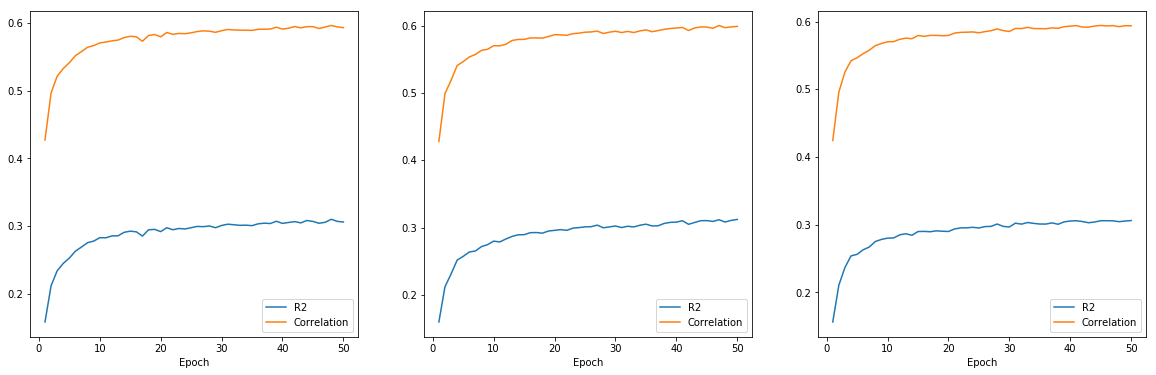

In [10]:
%%time
activation = tf.nn.relu
initializer = None
regularizer = None
epochs = 50
batch_size = 1000
val_split = 0.2
size = 3
num_files = 10
Timestamp = 6

datasets = ["Tau_12", "Tau_13", "Tau_23"]
results = {}
i = 1
k = 1
os.chdir(path+"/Saved_Models_2Sets")
print("Box size used: " + str((2 * size + 1, 2 * size + 1, 2 * size + 1, 3)))
fig = plt.figure(figsize = (20, 6))
for name in datasets:
    x_test = []
    y_test = []
    print("\nPredicting " + name)
    input_shape =  (Timestamp,(2 * size + 1)*( 2 * size + 1)*( 2 * size + 1)* 3)
    neural_net = LSTM(activation, initializer, regularizer, input_shape)
    model = neural_net.create_model()
    model.compile(optimizer = tf.train.RMSPropOptimizer(learning_rate = 0.01), loss = "mse")
    correlation = []
    R2 = []
    for i in range(epochs):
        temp_1 = []
        temp_2 = []        
        files_range = np.arange(1, num_files * 2 + 1)
        np.random.shuffle(files_range)
        for j in files_range:
            # Load Datasets
            print("\nRunning Dataset:" + name + ": Epoch: " + str(i) + ": fileSet: " + str(j)) 
            x = np.load(path + "/Train_Data/Data/" + str(j) + ".npy")
            y = np.load(path + "/Train_Data/Labels/" + name + "/" + str(j) + ".npy")
            
            # Create Train and Test sets
            mask =  np.random.rand(x.shape[0]) < 0.80
            x_train = x[mask,:,:,:,:]
            y_train = y[mask]
            x_test = x[~mask,:,:,:,:]
            y_test = y[~mask]
            del y
            del mask
            gc.collect()
            x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],-1))
            y_train = np.reshape(y_train,(y_train.shape[0],y_train.shape[1],-1))
            x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],-1))

            model.fit(x_train, y_train, epochs = 1, validation_split = 0.2, batch_size = batch_size, verbose = 1)
            del x_train
            del y_train
            gc.collect()
            
            # Get Test corr and R2 and append to list
            y_pred = model.predict(x_test).flatten()
            gc.collect()
            y_true = y_test.flatten()
            temp_1.append(r2_score(y_true, y_pred))
            temp_2.append(np.corrcoef(y_pred, y_true)[0, 1])
            del x_test
            del y_test
            del x
            gc.collect()
            #i += 1
        
        # Get average Test corr and R2 for the epoch
        correlation.append(np.mean(temp_2))
        R2.append(np.mean(temp_1))
    
    #save model
    model_name_json = "model2_" + name + ".json"
    model_name_h5 = "model2_" + name + ".h5"
    model_json = model.to_json()
    with open(model_name_json, "w") as json_file:
        json_file.write(model_json)
    model.save_weights(model_name_h5)
    print("Saved model to disk\n")
    
    # Plot R2 and corr evolution
    fig.add_subplot(1, len(datasets), k)
    plt.plot(np.arange(1, epochs + 1), np.array(R2), label = 'R2')
    plt.plot(np.arange(1, epochs + 1), np.array(correlation), label = 'Correlation')
    plt.xlabel('Epoch')
    plt.legend()
    print("Final Dataset Correlation: %.4f" % np.corrcoef(y_pred, y_true)[0, 1])
    del y_pred
    del y_true
    gc.collect()
    
    k += 1

In [12]:
os.chdir(path+"/Saved_Models_2Sets")
##### Load Model for tau_12
json_file = open('model2_Tau_12.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_12 = model_from_json(loaded_model_json)

# load weights into new model
loaded_model_12.load_weights("model2_Tau_12.h5")
print("Loaded model 12 from disk")

# evaluate loaded model on test data 
# Define X_test & Y_test data first
loaded_model_12.compile(optimizer = tf.train.AdamOptimizer(), loss = "mse")

#### Load Model for tau_13
json_file = open('model2_Tau_13.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_13 = model_from_json(loaded_model_json)

# load weights into new model
loaded_model_13.load_weights("model2_Tau_13.h5")
print("Loaded model 13 from disk")

# evaluate loaded model on test data 
# Define X_test & Y_test data first
loaded_model_13.compile(optimizer = tf.train.AdamOptimizer(), loss = "mse")

#### Load Model for tau_23
json_file = open('model2_Tau_23.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_23 = model_from_json(loaded_model_json)

# load weights into new model
loaded_model_23.load_weights("model2_Tau_23.h5")
print("Loaded model 23 from disk")

# evaluate loaded model on test data 
# Define X_test & Y_test data first
loaded_model_23.compile(optimizer = tf.train.AdamOptimizer(), loss = "mse")

Loaded model 12 from disk
Loaded model 13 from disk
Loaded model 23 from disk


In [17]:

import math
from IPython.display import HTML, display
import tabulate
name = ['_DNS8.mat']
out = [["Data Source", "Result", "Tau_12", "Tau_13", "Tau_23"]]
dirs = [("Re15sh2_DNScoarse8",8),("Re15sh5_DNScoarse8",8),("Re15sh20_DNScoarse8",8)]
for (dataDir, coarse) in dirs:
    dirName = path + "/Data/" + dataDir
    os.chdir(dirName)
    print("Processing " + dirName)
    u,v,w,tau_12,tau_13,tau_23 = get_mutitime_x(t_range,name)   
    x = np.array([u, v, w])
    x = np.transpose(x, [1, 2, 3,4, 0])
    x = np.pad(x, ((0,0),(size,size), (size,size), (size,size), (0,0)), 'constant', constant_values = 0)
    
    
    sample = []
    size = 3
    y_tau_12 = []
    y_tau_13 = []
    y_tau_23 = []
    for i in tqdm_notebook(range(size, x.shape[1] - size)):
        for j in range(size, x.shape[2] - size):
            for k in range(size, x.shape[3] - size):
                sample.append(x[:,i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :])
                y_tau_23.append([tau_23[t][i - size][j - size][k - size] for t in range(6)])
                y_tau_12.append([tau_23[t][i - size][j - size][k - size] for t in range(6)])
                y_tau_13.append([tau_23[t][i - size][j - size][k - size] for t in range(6)])
            
    x = np.array(sample)
    y_tau_12 = np.array(y_tau_12).flatten()
    y_tau_13 = np.array(y_tau_13).flatten()
    y_tau_23 = np.array(y_tau_23).flatten()
    
    x = np.reshape(x,(x.shape[0],x.shape[1],-1))

    
    print("predicting tau_12")
    y_pred_12 = loaded_model_12.predict(x).flatten()


    print("predicting tau_13")
    y_pred_13 = loaded_model_13.predict(x).flatten()


    print("predicting tau_23")
    y_pred_23 = loaded_model_23.predict(x).flatten()

    out.append([dataDir, 'Corr', str(np.round(np.corrcoef(y_pred_12, y_tau_12)[0, 1], 4)), str(np.round(np.corrcoef(y_pred_13, y_tau_13)[0, 1], 4)), str(np.round(np.corrcoef(y_pred_23, y_tau_23)[0, 1], 4))])
    out.append(['', 'R^2', str(np.round(r2_score(y_tau_12, y_pred_12), 4)), str(np.round(r2_score(y_tau_13, y_pred_13), 4)), str(np.round(r2_score(y_tau_23, y_pred_23), 4))])
    
display(HTML(tabulate.tabulate(out, tablefmt = 'html')))

Processing /home/ubuntu/Capstone/Data/Re15sh2_DNScoarse8



predicting tau_12
predicting tau_13
predicting tau_23
Processing /home/ubuntu/Capstone/Data/Re15sh5_DNScoarse8


FileNotFoundError: [Errno 2] No such file or directory: 'u_F_xyz_T2_DNS8.mat'